## Importar Librerías

In [1]:
#!pip install xgboost
from ast import literal_eval
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
import ast
import chardet
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

## Preprocesamiento del CSV

In [2]:
def getIndicatorList(indicator):
    if (type(indicator)==str):
        indicator=literal_eval(indicator)
    arr=[]
    for i in range(len(indicator)):
        for j in range(len(indicator[i]['ids'])):
            arr.append(indicator[i]['ids'][j])
    return np.array(arr)

# Definir la función arrayToString
def arrayToString(arr):
    return ' '.join(map(str, sorted(arr)))

In [3]:
# Función para extraer el valor del campo 'action' de la columna 'mitigationStatus'
def get_action(mitigation_status):
    if pd.isna(mitigation_status):
        return None
    parsed_status = ast.literal_eval(mitigation_status)
    if isinstance(parsed_status, list) and len(parsed_status) > 0 and 'action' in parsed_status[0]:
        return parsed_status[0]['action']
    return None

In [4]:
# Función para extraer el valor del campo 'title' de la columna 'threatInfo.detectionEngines'
def get_title(detection_engines):
    if pd.isna(detection_engines):
        return None
    try:
        parsed_engines = ast.literal_eval(detection_engines)
        if isinstance(parsed_engines, list) and len(parsed_engines) > 0 and 'title' in parsed_engines[0]:
            return parsed_engines[0]['title']
    except (ValueError, SyntaxError):
        return None

In [5]:
# Ruta del archivo CSV proporcionado por el usuario
csv_file_path = "Path\file.csv"

# Detectar la codificación del archivo
with open(csv_file_path, 'rb') as f:
    result = chardet.detect(f.read(100000))
    encoding = result['encoding']

# Leer el archivo CSV utilizando la codificación detectada
df = pd.read_csv(csv_file_path, encoding=encoding, sep=None, engine='python')
df = df.drop(columns=["Unnamed: 0"], axis=1)

# Mostrar las primeras filas del DataFrame para verificar el contenido
#print(df.head())


In [6]:
    
# ThreatIndicatorList
df["indicatorList"] = df["indicators"].apply(getIndicatorList)

# Eliminar saltos de línea en 'indicatorList'
df['indicatorList'] = df['indicatorList'].apply(lambda x: ' '.join(str(x).split()))

# MitigationStatus
df['action'] = df['mitigationStatus'].apply(get_action)

# Aplicar la función a la columna 'threatInfo.detectionEngines'
if 'threatInfo.detectionEngines' in df.columns:
    df['engine'] = df['threatInfo.detectionEngines'].apply(get_title)
else:
    df['engine'] = None


In [7]:
# Función para preprocesar los valores en 'indicatorList'
def preprocess_indicator_list(val):
    if isinstance(val, str):
        # Reemplazar espacios con comas y agregar comas donde sea necesario
        val = val.replace(' ', ',')
        val = val.replace('[,', '[').replace(',]', ']')
        return ast.literal_eval(val)
    return val

# Aplicar la función de preprocesamiento
df['indicatorList'] = df['indicatorList'].apply(preprocess_indicator_list)

# Eliminar filas donde 'indicatorList' está vacío (después de asegurarnos que todos son listas)
df = df.drop(df[df['indicatorList'].apply(lambda x: isinstance(x, list) and len(x) == 0)].index)

# Convertir 'indicatorList' a una cadena de texto ordenada
def arrayToString(arr):
    if isinstance(arr, list):
        return ' '.join(map(str, sorted(arr)))
    return str(arr)

df['indicatorListString'] = df['indicatorList'].apply(arrayToString)

# Eliminar filas duplicadas basadas en 'threatInfo.sha1'
##df = df.drop_duplicates(subset=['threatInfo.sha1'])
df = df.drop_duplicates(subset=['threatInfo.threatName'])

# Mostrar las columnas 'id', 'indicatorList', y 'threatInfo.sha1'
df_subset = df[["id", "indicatorList", "threatInfo.sha1"]]

Hay algunas amenazas (menos de 30) que no se analizan bien porque contienen una coma en alguna descripción; las descartamos. Para hacerlo, tomamos como referencia el valor de la columna threatInfo.confidenceLevel, que siempre es malicioso o sospechoso. Si tiene otro valor, significa que fue analizado incorrectamente..

In [8]:
# Crear un subconjunto del DataFrame con las columnas especificadas
subset_columns = df[[
    "threatInfo.threatId",
    "threatInfo.threatName",
    "threatInfo.classification",
    "threatInfo.confidenceLevel",
    "threatInfo.analystVerdict",
    "threatInfo.createdAt",
    "threatInfo.identifiedAt",
    "threatInfo.updatedAt",
    "indicatorList",
    "indicatorListString",
    "threatInfo.detectionType",
    "action",
    "threatInfo.sha1",
    "engine"
]]

# Filtrar las columnas que existen en el DataFrame
subset_columns = [col for col in subset_columns if col in df.columns]

# Crear el subconjunto del DataFrame
subset_df = df[subset_columns]

# Filtrar las filas donde el valor de la columna 'threatInfo.confidenceLevel' es 'malicious' o 'suspicious'
filtered_df = subset_df[subset_df['threatInfo.confidenceLevel'].isin(['malicious', 'suspicious'])]

# Guardar el subconjunto del DataFrame en un nuevo archivo CSV
filtered_df.to_csv('C:\\Users\\alber\\Documents\\Máster IA de UNIR\\Asignaturas\\TFE\\Código\\Subset.csv', index=False)

print("El archivo CSV con el subconjunto especificado se ha guardado correctamente.")

El archivo CSV con el subconjunto especificado se ha guardado correctamente.


## EDA

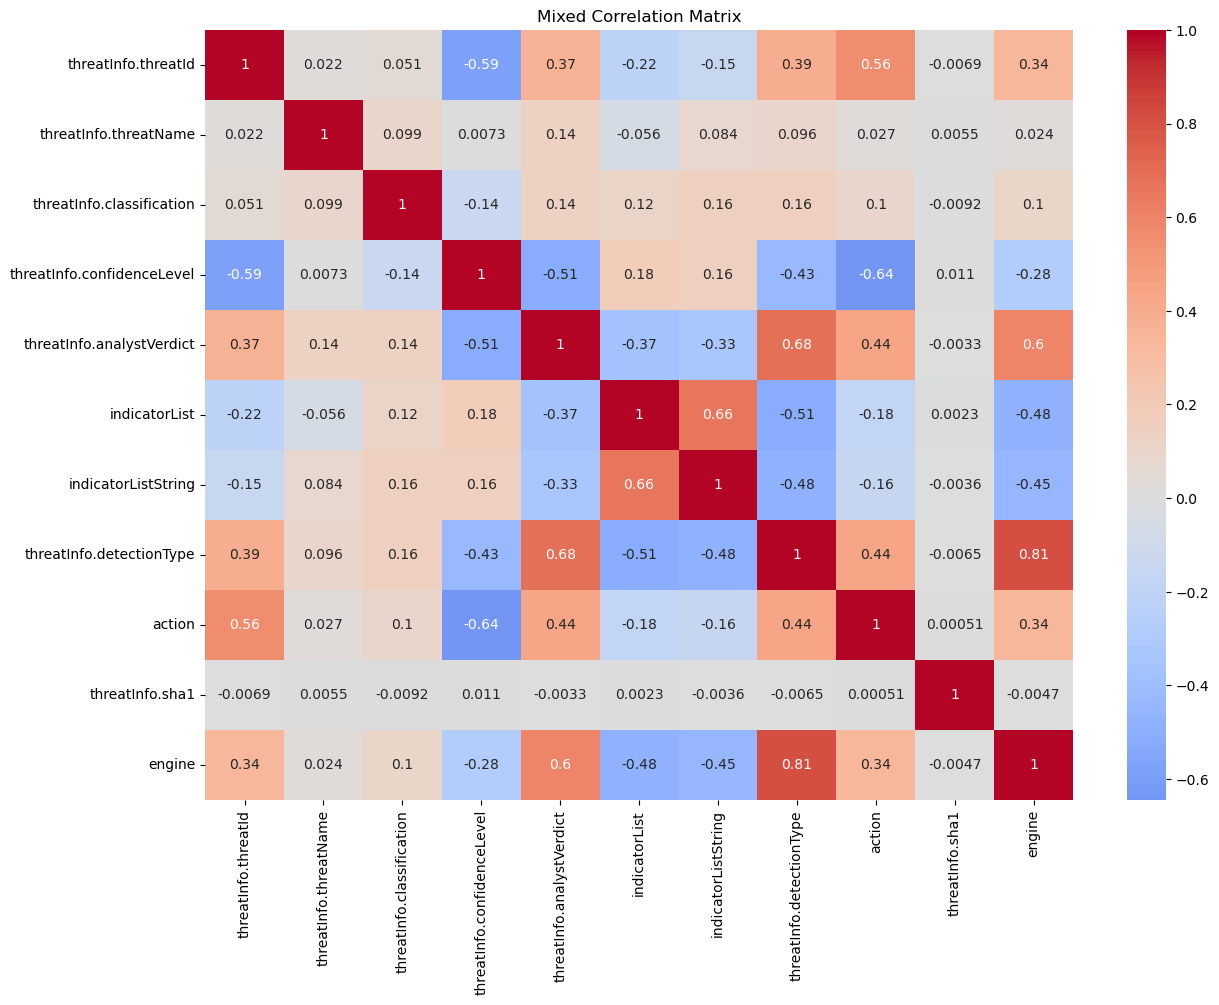


Top Correlaciones Más Fuertes:
                      Variable 1                  Variable 2  Correlation
87     threatInfo.detectionType                      engine     0.812652
117                      engine    threatInfo.detectionType     0.812652
81     threatInfo.detectionType   threatInfo.analystVerdict     0.683442
51    threatInfo.analystVerdict    threatInfo.detectionType     0.683442
71          indicatorListString               indicatorList     0.659411
61                indicatorList         indicatorListString     0.659411
91                       action  threatInfo.confidenceLevel    -0.644670
41   threatInfo.confidenceLevel                      action    -0.644670
114                      engine   threatInfo.analystVerdict     0.595757
54    threatInfo.analystVerdict                      engine     0.595757
3           threatInfo.threatId  threatInfo.confidenceLevel    -0.591145
33   threatInfo.confidenceLevel         threatInfo.threatId    -0.591145
88                

In [9]:
from scipy.stats import spearmanr, kendalltau
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

# Crear un subconjunto del DataFrame con las columnas sin tiempo
subset_columns = df[[
    "threatInfo.threatId",
    "threatInfo.threatName",
    "threatInfo.classification",
    "threatInfo.confidenceLevel",
    "threatInfo.analystVerdict",
    "indicatorList",
    "indicatorListString",
    "threatInfo.detectionType",
    "action",
    "threatInfo.sha1",
    "engine"
]]

# Filtrar las columnas que existen en el DataFrame
subset_columns = [col for col in subset_columns if col in df.columns]

# Crear el subconjunto del DataFrame
subset_df = df[subset_columns]
df = subset_df

# Definir una función para calcular la matriz de correlación mixta
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    numerator = np.sum(np.multiply(n_array, np.power(np.subtract(y_avg_array, y_total_avg), 2)))
    denominator = np.sum(np.power(np.subtract(measurements, y_total_avg), 2))
    if numerator == 0:
        return 0.0
    else:
        return np.sqrt(numerator / denominator)

# Convertir variables categóricas en etiquetas numéricas para calcular correlaciones
le = LabelEncoder()
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

# Calcular la matriz de correlación mixta
correlation_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

for col1 in df.columns:
    for col2 in df.columns:
        if df[col1].dtype == 'object' or df[col2].dtype == 'object':
            correlation_matrix.loc[col1, col2] = correlation_ratio(df[col1], df[col2])
        else:
            correlation_matrix.loc[col1, col2] = np.corrcoef(df[col1], df[col2])[0, 1]

correlation_matrix = correlation_matrix.astype(float)

# Visualizar la matriz de correlación mixta
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Mixed Correlation Matrix')
plt.show()

# Obtener el top 5 de correlaciones más fuertes (excluyendo la diagonal)
corr_pairs = correlation_matrix.unstack().reset_index()
corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
corr_pairs = corr_pairs[corr_pairs['Variable 1'] != corr_pairs['Variable 2']]
top_5_correlations = corr_pairs.reindex(corr_pairs.Correlation.abs().sort_values(ascending=False).index).head(20)

print("\nTop Correlaciones Más Fuertes:\n", top_5_correlations)

In [57]:
# Gráfico de Barras Apiladas
#plt.figure(figsize=(14, 7))
#sns.countplot(data=filtered_df, x='engine', hue='threatInfo.analystVerdict')
#plt.title('Distribución de "engine" por "threatInfo.analystVerdict"')
#plt.xticks(rotation=45)
#plt.show()

In [58]:
# Crear una tabla cruzada
#cross_tab = pd.crosstab(filtered_df['engine'], filtered_df['threatInfo.analystVerdict'])

# Heatmap
#plt.figure(figsize=(14, 7))
#sns.heatmap(cross_tab, annot=True, fmt="d", cmap="YlGnBu")
#plt.title('Heatmap de "engine" y "threatInfo.analystVerdict"')
#plt.show()

In [59]:
# Contar frecuencias de cada combinación
#freq = filtered_df.groupby(['engine', 'threatInfo.analystVerdict']).size().reset_index(name='counts')

# Gráfico de Barras
#plt.figure(figsize=(14, 7))
#sns.barplot(data=freq, x='engine', y='counts', hue='threatInfo.analystVerdict')
#plt.title('Frecuencia de "engine" por "threatInfo.analystVerdict"')
#plt.xticks(rotation=45)
#plt.show()

This function returns the index if the value passed in the argument is contained in the array passed in the argument otherwise returns -1.

In [60]:
# Calcular porcentajes
engine_verdict_counts = filtered_df.groupby(['engine', 'threatInfo.analystVerdict']).size().reset_index(name='counts')
total_counts = engine_verdict_counts.groupby('engine')['counts'].transform('sum')
engine_verdict_counts['percentage'] = engine_verdict_counts['counts'] / total_counts * 100

# Gráfico de Barras Apiladas con Porcentajes
#plt.figure(figsize=(14, 7))
#sns.barplot(data=engine_verdict_counts, x='engine', y='percentage', hue='threatInfo.analystVerdict')
#plt.title('Distribución de "engine" por "threatInfo.analystVerdict" (Porcentajes)')
#plt.ylabel('Porcentaje')
#plt.xticks(rotation=45)
#plt.show()

In [61]:
# Crear una tabla cruzada con conteos
#cross_tab = pd.crosstab(filtered_df['engine'], filtered_df['threatInfo.analystVerdict'], normalize='index') * 100

# Heatmap con Porcentajes
#plt.figure(figsize=(14, 7))
#sns.heatmap(cross_tab, annot=True, fmt=".1f", cmap="YlGnBu")
#plt.title('Heatmap de "engine" y "threatInfo.analystVerdict" (Porcentajes)')
#plt.ylabel('Engine')
#plt.xlabel('ThreatInfo Analyst Verdict')
#plt.show()

In [62]:
# Calcular porcentajes
engine_verdict_counts = filtered_df.groupby(['engine', 'threatInfo.analystVerdict']).size().reset_index(name='counts')
total_counts = engine_verdict_counts.groupby('engine')['counts'].transform('sum')
engine_verdict_counts['percentage'] = engine_verdict_counts['counts'] / total_counts * 100

# Gráfico de Barras con Porcentajes
#plt.figure(figsize=(14, 7))
#sns.barplot(data=engine_verdict_counts, x='engine', y='percentage', hue='threatInfo.analystVerdict')
#plt.title('Frecuencia de "engine" por "threatInfo.analystVerdict" (Porcentajes)')
#plt.ylabel('Porcentaje')
#plt.xticks(rotation=45)
#plt.show()

In [64]:
# Contar el número de threatInfo.threatId por cada valor de engine
engine_counts = filtered_df.groupby('engine')['threatInfo.threatId'].count()

# Crear el gráfico de quesitos
#plt.figure(figsize=(12, 8))
#wedges, texts, autotexts = plt.pie(
#    engine_counts, autopct='%1.1f%%', startangle=140, pctdistance=0.85, textprops=dict(color="w")
#)

# Añadir estilo a los textos
#for text in texts:
#    text.set_color('black')
#    text.set_fontsize(10)
#for autotext in autotexts:
#    autotext.set_color('black')
#    autotext.set_fontsize(8)

# Añadir leyenda fuera del gráfico
#plt.legend(wedges, engine_counts.index, title="Engine", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

#plt.title('Distribución de threatInfo.threatId por engine')
#plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#plt.show()

(-1.099998188724003,
 1.0999998059146114,
 -1.0999992320337983,
 1.0999994632910233)

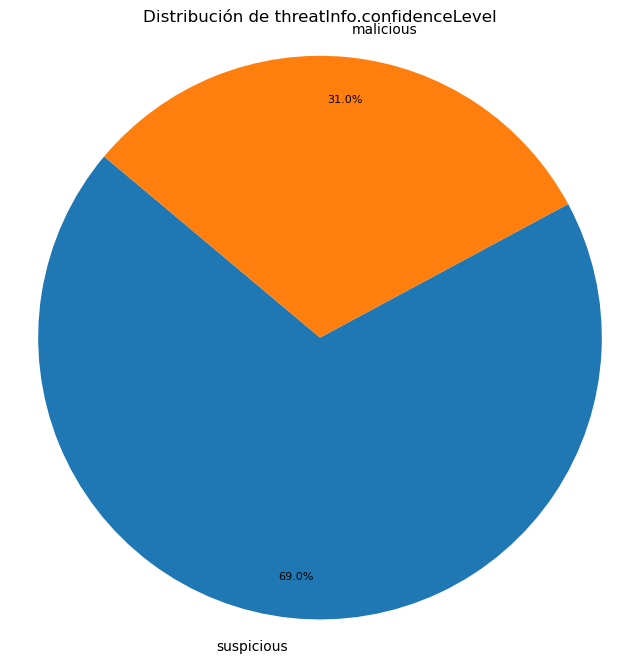

In [17]:
# Contar el número de ocurrencias por cada valor de threatInfo.confidenceLevel
confidence_level_counts = filtered_df['threatInfo.confidenceLevel'].value_counts()

# Crear el gráfico de quesitos para threatInfo.confidenceLevel
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    confidence_level_counts, labels=confidence_level_counts.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85
)

# Añadir estilo a los textos
for text in texts:
    text.set_color('black')
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(8)

plt.title('Distribución de threatInfo.confidenceLevel')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#plt.show()

(-1.0999985394527296,
 1.0999917190339914,
 -1.0999996626057194,
 1.0999929310732295)

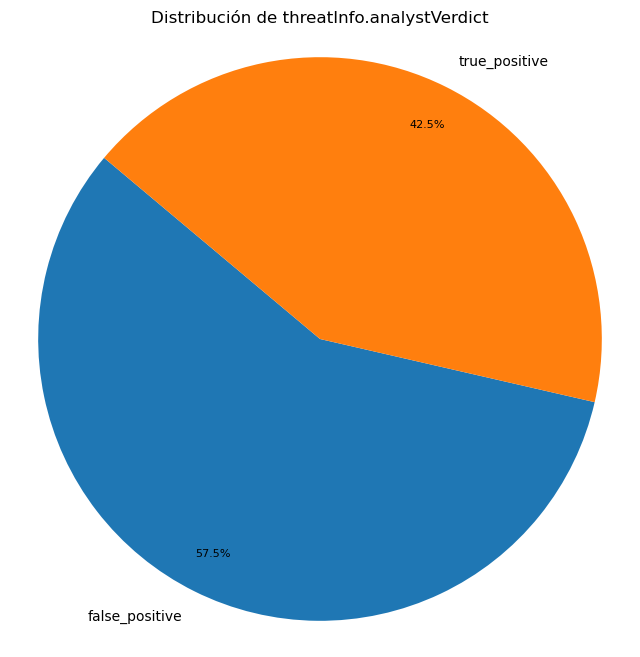

In [18]:
# Contar el número de ocurrencias por cada valor de threatInfo.analystVerdict
analyst_verdict_counts = filtered_df['threatInfo.analystVerdict'].value_counts()

# Crear el gráfico de quesitos para threatInfo.analystVerdict
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    analyst_verdict_counts, labels=analyst_verdict_counts.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85
)

# Añadir estilo a los textos
for text in texts:
    text.set_color('black')
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(8)

plt.title('Distribución de threatInfo.analystVerdict')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#plt.show()

In [65]:
# Crear una tabla cruzada con conteos
cross_tab = pd.crosstab(filtered_df['threatInfo.classification'], filtered_df['threatInfo.analystVerdict'], normalize='index') * 100

# Heatmap con Porcentajes
#plt.figure(figsize=(14, 7))
#sns.heatmap(cross_tab, annot=True, fmt=".1f", cmap="YlGnBu")
#plt.title('Heatmap de "threatInfo.classification" y "threatInfo.analystVerdict" (Porcentajes)')
#plt.ylabel('Classification')
#plt.xlabel('ThreatInfo Analyst Verdict')
#plt.show()

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una tabla cruzada con conteos
cross_tab_counts = pd.crosstab(filtered_df['threatInfo.classification'], filtered_df['threatInfo.analystVerdict'])

# Heatmap con Conteos
#plt.figure(figsize=(14, 7))
#sns.heatmap(cross_tab_counts, annot=True, fmt="d", cmap="YlGnBu")
#plt.title('Heatmap de "threatInfo.classification" y "threatInfo.analystVerdict"')
#plt.ylabel('Classification')
#plt.xlabel('ThreatInfo Analyst Verdict')
#plt.show()

(-1.0999999577167858,
 1.0999999595852634,
 -1.0999999604691062,
 1.0999999967519045)

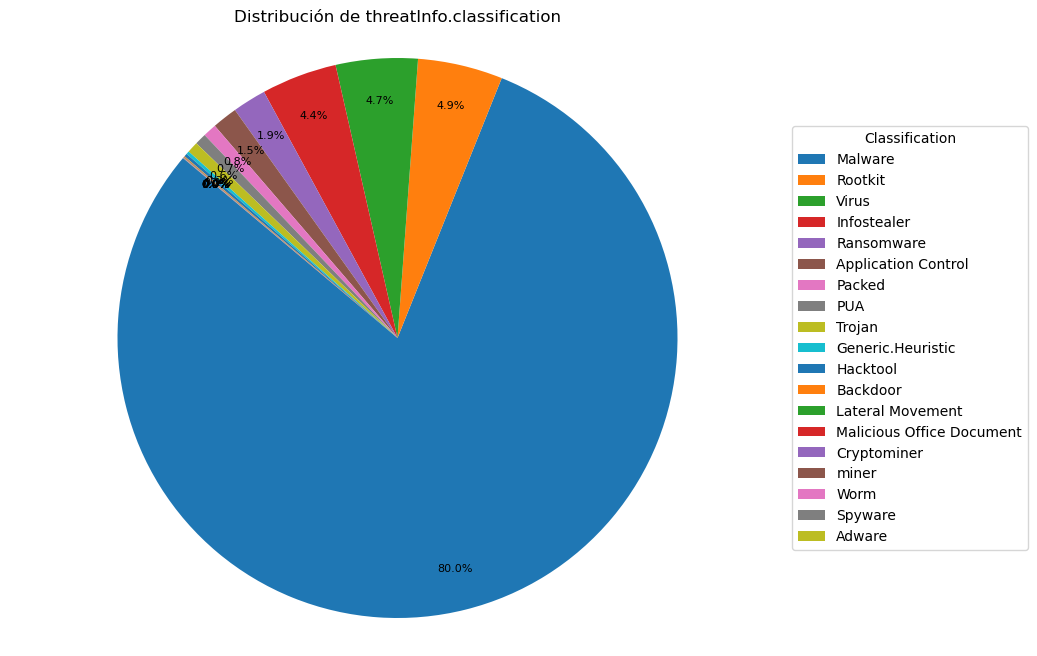

In [21]:
# Contar el número de ocurrencias por cada valor de threatInfo.classification
classification_counts = filtered_df['threatInfo.classification'].value_counts()

# Crear el gráfico de quesitos para threatInfo.classification
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    classification_counts, autopct='%1.1f%%', startangle=140, pctdistance=0.85, textprops=dict(color="w")
)

# Añadir estilo a los textos
for text in texts:
    text.set_color('black')
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(8)

# Añadir leyenda fuera del gráfico
plt.legend(wedges, classification_counts.index, title="Classification", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribución de threatInfo.classification')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#plt.show()

In [67]:

# Convertir las columnas temporales a datetime
filtered_df['threatInfo.identifiedAt'] = pd.to_datetime(filtered_df['threatInfo.identifiedAt'], errors='coerce')
filtered_df['threatInfo.createdAt'] = pd.to_datetime(filtered_df['threatInfo.createdAt'], errors='coerce')
filtered_df['threatInfo.updatedAt'] = pd.to_datetime(filtered_df['threatInfo.updatedAt'], errors='coerce')

# Eliminar filas con valores nulos en las columnas de tiempo
filtered_df = filtered_df.dropna(subset=['threatInfo.identifiedAt', 'threatInfo.createdAt', 'threatInfo.updatedAt'])

# Mostrar las primeras filas del DataFrame para verificar los cambios
filtered_df[['threatInfo.identifiedAt', 'threatInfo.createdAt', 'threatInfo.updatedAt']].head()

# Visualizar las columnas temporales en un gráfico con Datetime en el eje x
#plt.figure(figsize=(12, 6))
#plt.plot(filtered_df['threatInfo.identifiedAt'], filtered_df.index, label='Identified At')
#plt.plot(filtered_df['threatInfo.createdAt'], filtered_df.index, label='Created At')
#plt.plot(filtered_df['threatInfo.updatedAt'], filtered_df.index, label='Updated At')
#plt.xlabel('Datetime')
#plt.ylabel('Index (Row Number)')
#plt.title('Timestamps in Threat Information')
#plt.legend()
#plt.show()

,threatInfo.identifiedAt,threatInfo.createdAt,threatInfo.updatedAt
0,2024-03-01 01:18:41.826000+00:00,2024-03-01 01:18:42.146813+00:00,2024-03-01 02:25:07.204968+00:00
1,2024-02-29 13:35:53.370000+00:00,2024-03-01 02:14:05.728871+00:00,2024-03-01 02:25:08.402409+00:00
2,2024-03-01 02:25:44.162000+00:00,2024-03-01 02:25:44.706578+00:00,2024-03-01 03:24:36.034017+00:00
3,2024-03-01 02:54:35.638000+00:00,2024-03-01 02:54:37.170147+00:00,2024-03-01 03:27:24.063670+00:00
4,2024-03-01 03:04:18.382000+00:00,2024-03-01 03:04:19.873210+00:00,2024-03-01 03:26:02.379082+00:00


### Análisis de los Threat Indicators

In [23]:
def find_get_index(val, arr):
    for i in range(len(arr)):
        if(val == arr[i]):
            return i
    return -1

In [24]:
indicator_count ={"indicator":[], "count":[]}
for i in range(len(filtered_df)):
    for j in filtered_df.iloc[i]['indicatorList']:
        try:
            index = find_get_index(j,indicator_count['indicator'])
            #print(j,index)
            if(index>=0):
                indicator_count['count'][index] = indicator_count['count'][index]+1
            else:
                indicator_count['indicator'].append(j)
                indicator_count['count'].append(1)
        except:
            print(f"Caught Exception: Failed to create indicator count dataframe. \nState: Indicator: {j}\nDataFrame Index: {i}")
indicator_count_df= pd.DataFrame.from_dict(indicator_count)
indicator_count_df.head(5)


,indicator,count
0,24,2605
1,7,372
2,6,2122
3,1,3289
4,817,80


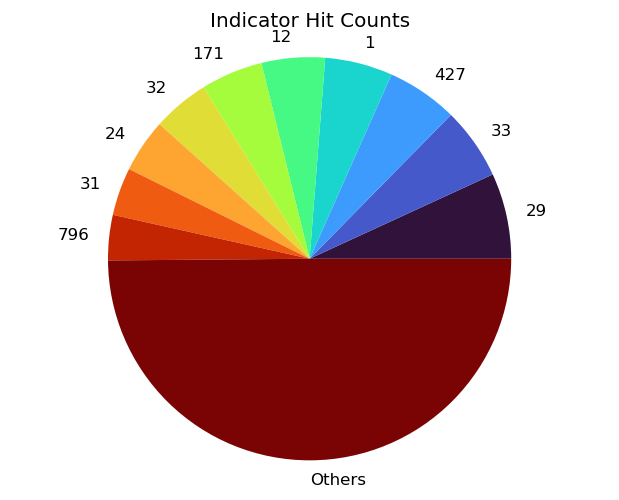

In [25]:
indicator_count_df = indicator_count_df.sort_values(by="count", ascending=False)
TopCount = 10
top_indicators = indicator_count_df.head(TopCount)
remaining_values = pd.Series({'indicator':"Others","count":indicator_count_df['count'][TopCount:].sum()})

final_indicator_count_df = pd.concat([top_indicators,remaining_values.to_frame().T])


colormap = plt.cm.turbo
colors = colormap(np.linspace(0,1,TopCount+1))
plt.rcParams['figure.dpi'] = 120
plt.pie(final_indicator_count_df["count"], labels=final_indicator_count_df["indicator"], colors=colors)
plt.title("Indicator Hit Counts")
plt.axis("equal")
plt.show()
#fig.show()

# Indicators for True Positives

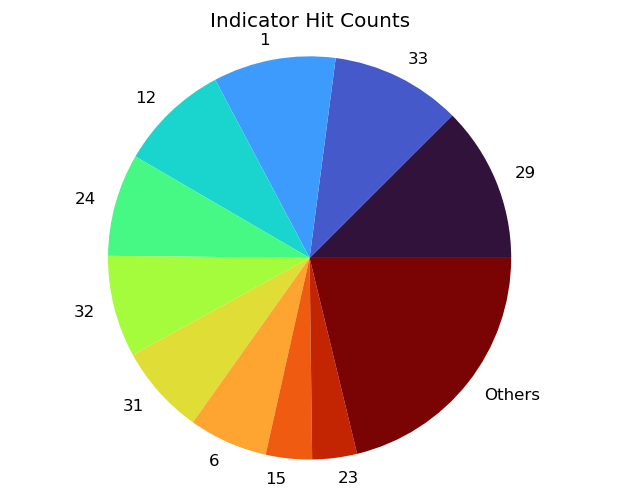

In [26]:
indicator_count ={"indicator":[], "count":[]}
for i in range(len(filtered_df)):
    if(filtered_df.iloc[i]['threatInfo.analystVerdict']=="true_positive"):
        for j in filtered_df.iloc[i]['indicatorList']:
            try:
                index = find_get_index(j,indicator_count['indicator'])
                #print(j,index)
                if(index>=0):
                    indicator_count['count'][index] = indicator_count['count'][index]+1
                else:
                    indicator_count['indicator'].append(j)
                    indicator_count['count'].append(1)
            except:
                print(f"Caught Exception: Failed to create indicator count dataframe. \nState: Indicator: {j}\nDataFrame Index: {i}")
indicator_count_df= pd.DataFrame.from_dict(indicator_count)
indicator_count_df.head(5)
#indicator_df=pd.DataFrame.from_dict(indicator_count)
#indicator_df


indicator_count_df = indicator_count_df.sort_values(by="count", ascending=False)
TopCount = 10
top_indicators = indicator_count_df.head(TopCount)
remaining_values = pd.Series({'indicator':"Others","count":indicator_count_df['count'][TopCount:].sum()})

final_indicator_count_df = pd.concat([top_indicators,remaining_values.to_frame().T])


colormap = plt.cm.turbo
colors = colormap(np.linspace(0,1,TopCount+1))
plt.rcParams['figure.dpi'] = 120
plt.pie(final_indicator_count_df["count"], labels=final_indicator_count_df["indicator"], colors=colors)
plt.title("Indicator Hit Counts")
plt.axis("equal")
plt.show()

# Indicators for False Positives

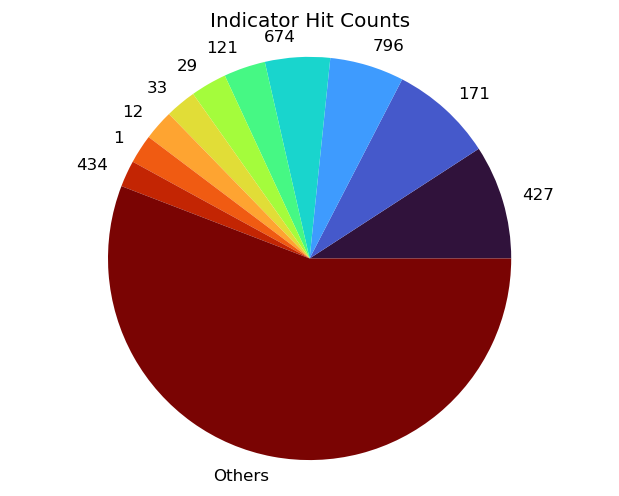

In [27]:
indicator_count ={"indicator":[], "count":[]}
for i in range(len(filtered_df)):
    if(filtered_df.iloc[i]['threatInfo.analystVerdict']=="false_positive"):
        for j in filtered_df.iloc[i]['indicatorList']:
            try:
                index = find_get_index(j,indicator_count['indicator'])
                #print(j,index)
                if(index>=0):
                    indicator_count['count'][index] = indicator_count['count'][index]+1
                else:
                    indicator_count['indicator'].append(j)
                    indicator_count['count'].append(1)
            except:
                print(f"Caught Exception: Failed to create indicator count dataframe. \nState: Indicator: {j}\nDataFrame Index: {i}")
indicator_count_df= pd.DataFrame.from_dict(indicator_count)
indicator_count_df.head(5)
#indicator_df=pd.DataFrame.from_dict(indicator_count)
#indicator_df


indicator_count_df = indicator_count_df.sort_values(by="count", ascending=False)
TopCount = 10
top_indicators = indicator_count_df.head(TopCount)
remaining_values = pd.Series({'indicator':"Others","count":indicator_count_df['count'][TopCount:].sum()})

final_indicator_count_df = pd.concat([top_indicators,remaining_values.to_frame().T])


colormap = plt.cm.turbo
colors = colormap(np.linspace(0,1,TopCount+1))
plt.rcParams['figure.dpi'] = 120
plt.pie(final_indicator_count_df["count"], labels=final_indicator_count_df["indicator"], colors=colors)
plt.title("Indicator Hit Counts")
plt.axis("equal")
plt.show()

In [28]:
le = preprocessing.LabelEncoder()
filtered_df['threatInfo.analystVerdict.encoded'] = le.fit_transform(filtered_df['threatInfo.analystVerdict'])
filtered_df[['threatInfo.analystVerdict.encoded','threatInfo.analystVerdict']]

,threatInfo.analystVerdict.encoded,threatInfo.analystVerdict
0,1,true_positive
1,1,true_positive
2,0,false_positive
3,1,true_positive
4,1,true_positive
...,...,...
22059,1,true_positive
22064,0,false_positive
22065,0,false_positive
22073,0,false_positive


In [29]:
print((indicator_count_df['indicator']).to_string())

25      427
9       171
60      796
6       674
61      121
50       29
52       33
39       12
54        1
70      434
47      269
51       32
7        62
23      126
15      437
16       43
193     937
62      799
49      114
10     1273
38       24
40        6
55       31
21      153
5       145
137     137
14      266
48      951
1       199
66      169
73      294
132     122
96      769
17      293
42       23
102     201
59      198
97      768
56       30
94      359
189     243
53       15
20      154
235     412
13      916
4       688
95      724
63       41
92       88
78      711
18      163
120      18
33      641
130     104
8       725
80      894
81       98
36      311
77     1271
82      298
41       25
111     784
98      146
101     798
110     151
126     584
123     783
139     197
128     342
28      312
67      305
135     368
72      264
168      49
87     1303
86      633
146     224
22     1161
74       10
76       20
2        86
0       817
133     229
280 

In [30]:
indicator_count_df

,indicator,count
25,427,3256
9,171,2935
60,796,2117
6,674,1852
61,121,1189
...,...,...
228,235,1
303,546,1
302,544,1
301,993,1


In [31]:
filtered_df['threatInfo.analystVerdict'].value_counts()

threatInfo.analystVerdict
false_positive    7394
true_positive     5492
Name: count, dtype: int64

In [32]:
filtered_df.loc[df['threatInfo.analystVerdict']=="true_positive"]["indicatorListString"]


Series([], Name: indicatorListString, dtype: object)

In [33]:
filtered_df.loc[df['threatInfo.analystVerdict']=="false_positive"]["indicatorList"]

Series([], Name: indicatorList, dtype: object)

In [34]:
# Convertir 'indicatorListString' en una lista de strings
filtered_df['indicatorListString'] = filtered_df['indicatorListString'].apply(lambda x: x.split() if isinstance(x, str) else [])
print(filtered_df['indicatorListString'])

# Codificar 'indicatorList' utilizando MultiLabelBinarizer
mlb = MultiLabelBinarizer()
indicator_list_encoded = pd.DataFrame(mlb.fit_transform(filtered_df['indicatorListString']), columns=mlb.classes_, index=filtered_df.index)

print(indicator_list_encoded)

# Codificar 'engine' utilizando pd.get_dummies
engine_encoded = pd.get_dummies(filtered_df['engine'], prefix='engine')

# Codificar 'threatInfo.classification' utilizando pd.get_dummies
classification_encoded = pd.get_dummies(filtered_df['threatInfo.classification'], prefix='classification')

# Codificar 'threatInfo.confidenceLevel' utilizando pd.get_dummies
confidence_level_encoded = pd.get_dummies(filtered_df['threatInfo.confidenceLevel'], prefix='confidenceLevel')

# Codificar 'threatInfo.detectionType' utilizando pd.get_dummies
detection_type_encoded = pd.get_dummies(filtered_df['threatInfo.detectionType'], prefix='detectionType')

# Combinar todas las características codificadas en un solo DataFrame
characteristics_encoded = pd.concat([indicator_list_encoded, engine_encoded, classification_encoded, confidence_level_encoded, detection_type_encoded], axis=1)

# Verificar que las columnas de indicator_list_encoded están presentes
print("Columnas de indicator_list_encoded en characteristics_encoded:", set(indicator_list_encoded.columns).intersection(set(characteristics_encoded.columns)))

# Definir X y y
X = characteristics_encoded
y = filtered_df['threatInfo.analystVerdict.encoded']

# Convertir y a entero si es necesario
y = y.astype(int)

# Convertir todos los valores booleanos en X a enteros
X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Mostrar las dimensiones de los conjuntos de datos
print('Dimensiones de X_train:', X_train.shape)
print('Dimensiones de X_test:', X_test.shape)
print('Dimensiones de y_train:', y_train.shape)
print('Dimensiones de y_test:', y_test.shape)

# Verificar los tipos de datos de y_train
print("Tipos de datos de y_train:", y_train.dtypes)

# Aplicar SMOTE para equilibrar las clases
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


0                      [6, 7, 24]
1                             [1]
2                      [199, 817]
3                     [6, 12, 29]
4            [12, 20, 29, 31, 33]
                   ...           
22059                    [12, 15]
22064             [6, 23, 24, 25]
22065             [6, 23, 24, 25]
22073    [62, 121, 171, 427, 674]
22074             [6, 23, 24, 25]
Name: indicatorListString, Length: 12886, dtype: object
       1  10  101  1010  1016  1018  102  103  104  1046  ...  97  970  971  \
0      0   0    0     0     0     0    0    0    0     0  ...   0    0    0   
1      1   0    0     0     0     0    0    0    0     0  ...   0    0    0   
2      0   0    0     0     0     0    0    0    0     0  ...   0    0    0   
3      0   0    0     0     0     0    0    0    0     0  ...   0    0    0   
4      0   0    0     0     0     0    0    0    0     0  ...   0    0    0   
...   ..  ..  ...   ...   ...   ...  ...  ...  ...   ...  ...  ..  ...  ...   
22059  0   0    0

In [35]:
X_train

,1,10,101,1010,1016,1018,102,103,104,1046,...,classification_Rootkit,classification_Spyware,classification_Trojan,classification_Virus,classification_Worm,classification_miner,confidenceLevel_malicious,confidenceLevel_suspicious,detectionType_dynamic,detectionType_static
13799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
20316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
16927,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2397,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8841,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
5170,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
17210,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
18653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


# Entrenamiento de modelos

## Árbol de Decisiones

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


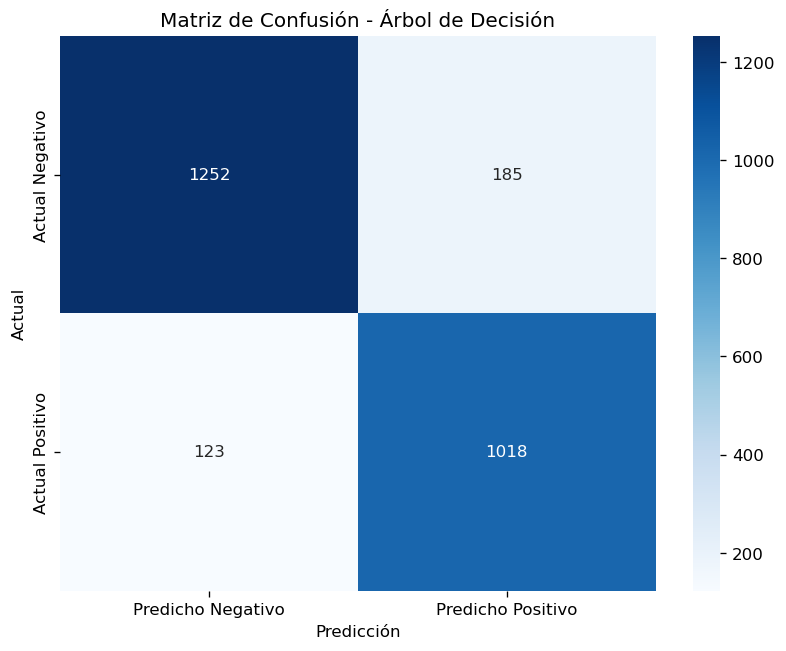

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1437
           1       0.85      0.89      0.87      1141

    accuracy                           0.88      2578
   macro avg       0.88      0.88      0.88      2578
weighted avg       0.88      0.88      0.88      2578

Reporte de clasificación en el conjunto de entrenamiento (para analizar el sobreajuste):
              precision    recall  f1-score   support

           0       0.94      0.89      0.92      5957
           1       0.86      0.93      0.89      4351

    accuracy                           0.91     10308
   macro avg       0.90      0.91      0.91     10308
weighted avg       0.91      0.91      0.91     10308



In [36]:
model = DecisionTreeClassifier(random_state=0)

# Definir los hiperparámetros para buscar
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Entrenar con los datos balanceados
grid_search.fit(X_resampled, y_resampled)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Usar el mejor modelo para predecir en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred))

# Evaluar en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_train)
print("Reporte de clasificación en el conjunto de entrenamiento (para analizar el sobreajuste):")
print(classification_report(y_train, y_train_pred))


## Modelo de Random Forest

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


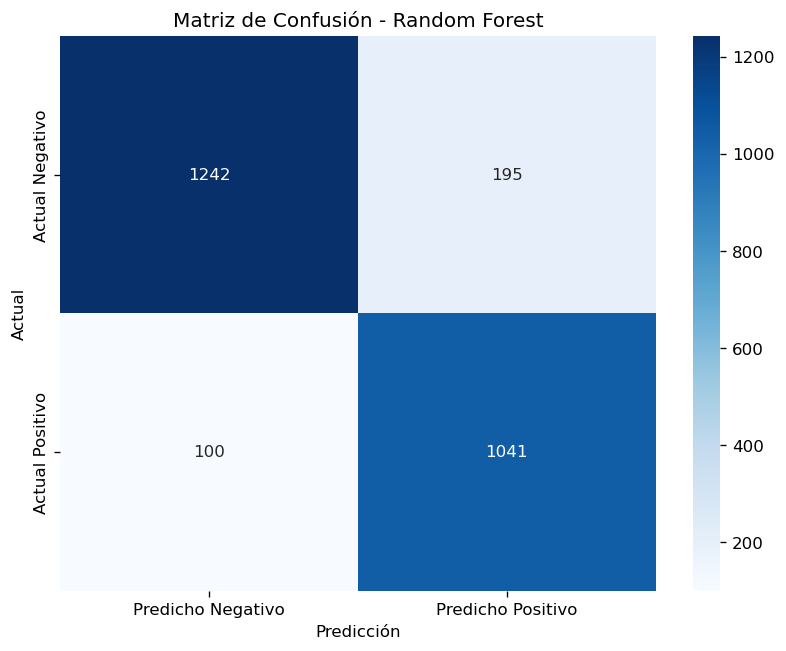

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1437
           1       0.84      0.91      0.88      1141

    accuracy                           0.89      2578
   macro avg       0.88      0.89      0.88      2578
weighted avg       0.89      0.89      0.89      2578

Random Forest Model Accuracy:  0.8914727289191244
Reporte de clasificación (Entrenamiento):
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      5957
           1       0.90      0.95      0.92      5957

    accuracy                           0.92     11914
   macro avg       0.92      0.92      0.92     11914
weighted avg       0.92      0.92      0.92     11914



In [37]:
# Definir el modelo y los parámetros para la búsqueda en cuadrícula
rf = RandomForestClassifier(random_state=0)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# Mejor modelo encontrado
best_rf = grid_search.best_estimator_
# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_rf.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred))

# Mostrar la exactitud del mejor modelo
print("Random Forest Model Accuracy: ", grid_search.best_score_)


# Evaluar el mejor modelo en el conjunto de entrenamiento para anlizar el sobreajuste
y_train_pred = best_rf.predict(X_resampled)

# Mostrar el reporte de clasificación para el conjunto de entrenamiento para analizar el sobreajuste
print("Reporte de clasificación (Entrenamiento):")
print(classification_report(y_resampled, y_train_pred))

### Uso de XGBoost con Validación Cruzada

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\alber\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


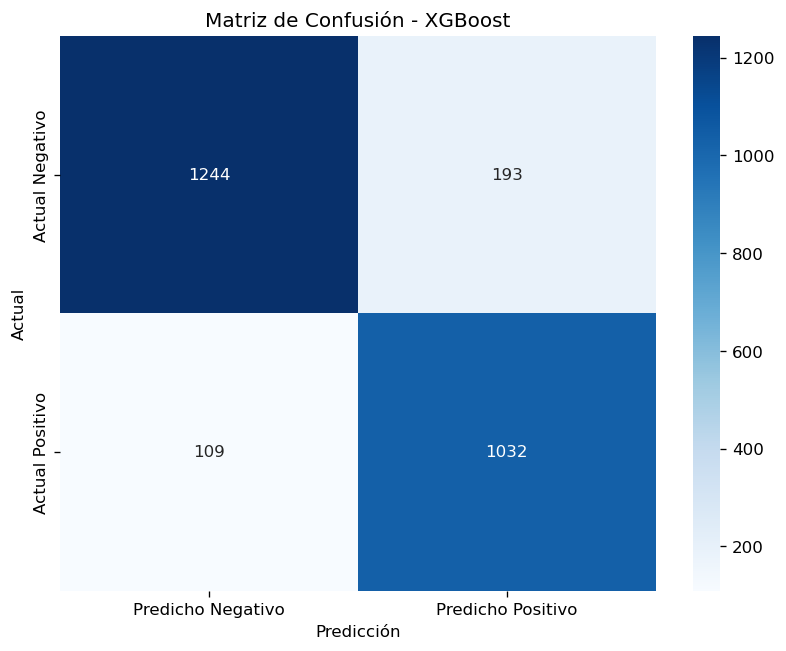

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1437
           1       0.84      0.90      0.87      1141

    accuracy                           0.88      2578
   macro avg       0.88      0.89      0.88      2578
weighted avg       0.89      0.88      0.88      2578

XGBoost Model Cross-Validation Accuracy:  0.8913892591414205


In [38]:
# Definir el modelo XGBoost
xgb_model = xgb.XGBClassifier(random_state=0)

# Definir los hiperparámetros para buscar
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Realizar búsqueda de hiperparámetros con validación cruzada
grid_search.fit(X_resampled, y_resampled)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Usar el mejor modelo para predecir en el conjunto de prueba
best_model = grid_search.best_estimator_

# Realizar validación cruzada con el mejor modelo
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='accuracy')

# Ajustar el mejor modelo en todo el conjunto de entrenamiento resampleado
best_model.fit(X_resampled, y_resampled)

# Predecir en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - XGBoost')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred))

# Mostrar la exactitud del modelo XGBoost con validación cruzada
print("XGBoost Model Cross-Validation Accuracy: ", cv_scores.mean())

### Uso de Modelos de Ensemble Avanzados

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores hiperparámetros: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}


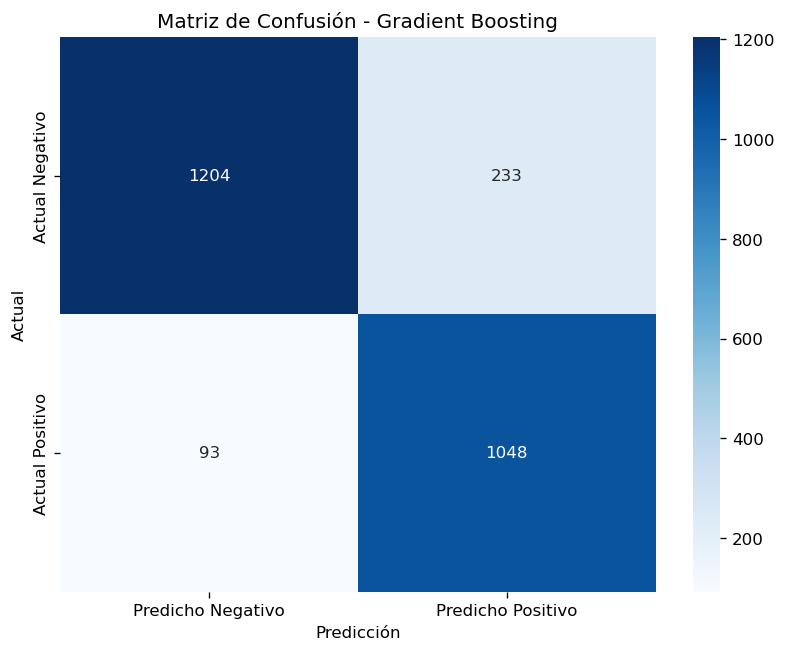

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1437
           1       0.82      0.92      0.87      1141

    accuracy                           0.87      2578
   macro avg       0.87      0.88      0.87      2578
weighted avg       0.88      0.87      0.87      2578

Gradient Boosting Model Accuracy:  0.884505944535055


In [39]:
# Definir el modelo Gradient Boosting
gb = GradientBoostingClassifier(random_state=0)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# Mejor modelo encontrado
best_gb = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_gb.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Gradient Boosting')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred))

# Mostrar la exactitud del mejor modelo
print("Gradient Boosting Model Accuracy: ", grid_search.best_score_)

###  Ingeniería de Características Adicionales

Fitting 5 folds for each of 18 candidates, totalling 90 fits


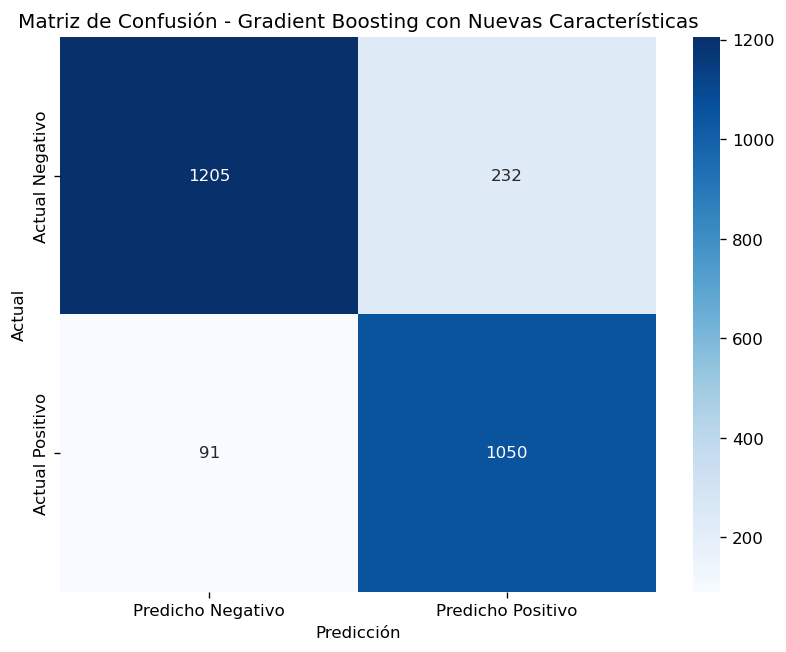

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1437
           1       0.82      0.92      0.87      1141

    accuracy                           0.87      2578
   macro avg       0.87      0.88      0.87      2578
weighted avg       0.88      0.87      0.88      2578

Gradient Boosting Model Accuracy con Nuevas Características:  0.8833306379183927


In [40]:
# Crear características adicionales
filtered_df['engine_confidence'] = filtered_df['engine'].astype(str) + '_' + filtered_df['threatInfo.confidenceLevel'].astype(str)
filtered_df['engine_classification'] = filtered_df['engine'].astype(str) + '_' + filtered_df['threatInfo.classification'].astype(str)

# Codificar las nuevas características utilizando pd.get_dummies
engine_confidence_encoded = pd.get_dummies(filtered_df['engine_confidence'], prefix='engine_confidence')
engine_classification_encoded = pd.get_dummies(filtered_df['engine_classification'], prefix='engine_classification')

# Combinar todas las características codificadas en un solo DataFrame
characteristics_encoded = pd.concat([indicator_list_encoded, engine_encoded, classification_encoded, confidence_level_encoded, detection_type_encoded, engine_confidence_encoded, engine_classification_encoded], axis=1)

# Definir X y y
X = characteristics_encoded
y = filtered_df['threatInfo.analystVerdict.encoded']

# Convertir y a entero si es necesario
y = y.astype(int)

# Convertir todos los valores booleanos en X a enteros
X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Dividir los datos en conjuntos de entrenamiento y prueba con un tamaño de prueba del 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Aplicar SMOTE para equilibrar las clases
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Definir el modelo Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=0)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Realizar la búsqueda en cuadrícula
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# Mejor modelo encontrado
best_gb = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_gb.predict(X_test)

# Calcular la matriz de confusión
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Gradient Boosting con Nuevas Características')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred))

# Mostrar la exactitud del mejor modelo
print("Gradient Boosting Model Accuracy con Nuevas Características: ", grid_search.best_score_)

## Modelo de Regresión Logística

Mejor F1-Score: 0.8592653735039207
Mejor Umbral: 0.5634449227632564


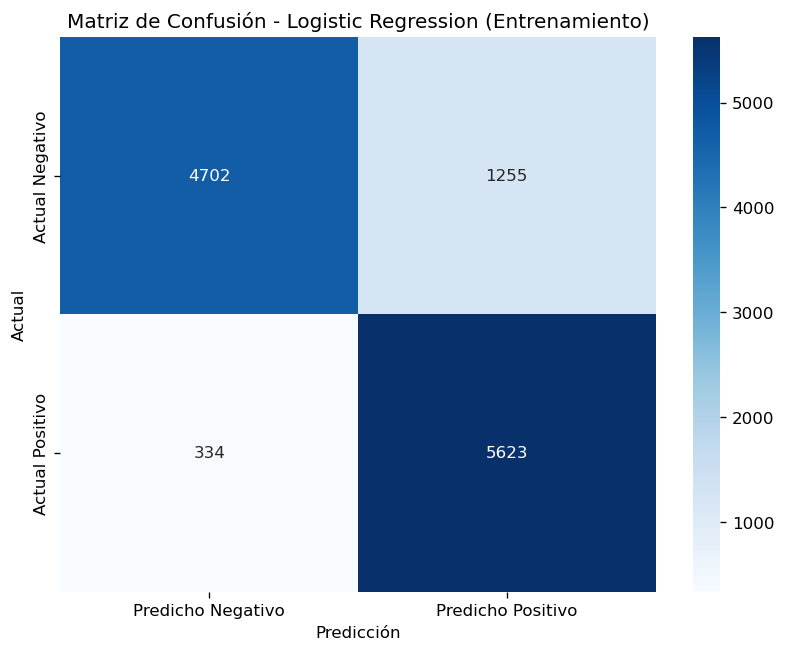

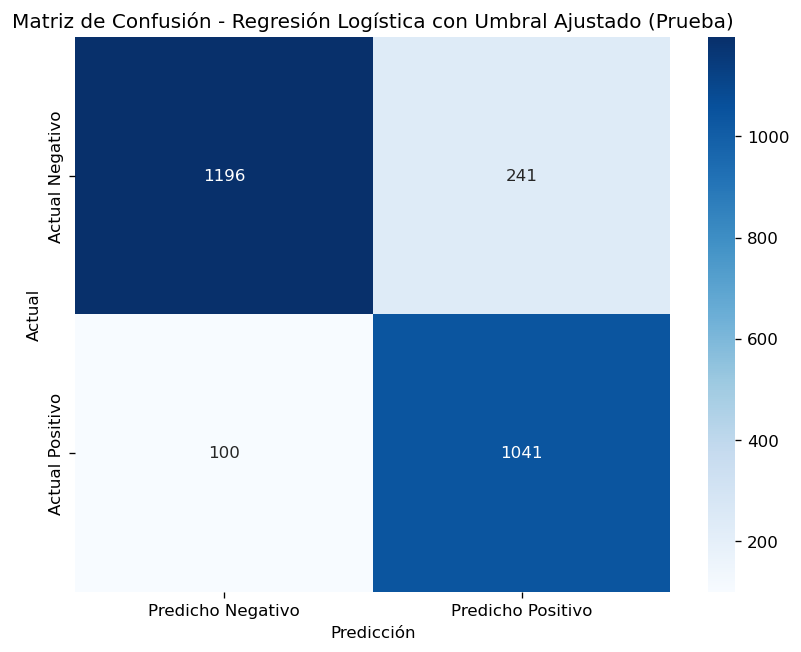

Reporte de clasificación (Entrenamiento):
              precision    recall  f1-score   support

           0       0.93      0.79      0.86      5957
           1       0.82      0.94      0.88      5957

    accuracy                           0.87     11914
   macro avg       0.88      0.87      0.87     11914
weighted avg       0.88      0.87      0.87     11914

Reporte de clasificación (Prueba con Umbral Ajustado):
              precision    recall  f1-score   support

           0       0.92      0.83      0.88      1437
           1       0.81      0.91      0.86      1141

    accuracy                           0.87      2578
   macro avg       0.87      0.87      0.87      2578
weighted avg       0.87      0.87      0.87      2578



In [41]:
# Definir el modelo Logistic Regression con hiperparámetros por defecto
lr = LogisticRegression(random_state=0, max_iter=1000)

# Entrenar el modelo con los datos balanceados
lr.fit(X_resampled, y_resampled)

# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = lr.predict(X_resampled)

# Evaluar el modelo en el conjunto de prueba
y_test_pred = lr.predict(X_test)
y_test_probs = lr.predict_proba(X_test)[:, 1]

# Calcular precisión, recall y umbrales para el conjunto de prueba
precision, recall, thresholds = precision_recall_curve(y_test, y_test_probs)

# Calcular F1-Score para cada umbral
f1_scores = 2 * (precision * recall) / (precision + recall)

# Encontrar el índice del mejor F1-Score
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]

print(f"Mejor F1-Score: {f1_scores[best_index]}")
print(f"Mejor Umbral: {best_threshold}")

# Aplicar el mejor umbral para las predicciones del conjunto de prueba
y_test_pred_adjusted = (y_test_probs >= best_threshold).astype(int)

# Calcular la matriz de confusión para el conjunto de entrenamiento
conf_matrix_train = confusion_matrix(y_resampled, y_train_pred)

# Calcular la nueva matriz de confusión para el conjunto de prueba con umbral ajustado
conf_matrix_test_adjusted = confusion_matrix(y_test, y_test_pred_adjusted)

# Visualizar la matriz de confusión para el conjunto de entrenamiento
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Logistic Regression (Entrenamiento)')
plt.show()

# Visualizar la nueva matriz de confusión para el conjunto de prueba con umbral ajustado
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Regresión Logística con Umbral Ajustado (Prueba)')
plt.show()

# Mostrar el reporte de clasificación para el conjunto de entrenamiento
print("Reporte de clasificación (Entrenamiento):")
print(classification_report(y_resampled, y_train_pred))

# Mostrar el nuevo reporte de clasificación para el conjunto de prueba con umbral ajustado
print("Reporte de clasificación (Prueba con Umbral Ajustado):")
print(classification_report(y_test, y_test_pred_adjusted))



### Modelo de Regresión Logística con búsqueda de hiperparámetros en rejilla

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores hiperparámetros: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor F1-Score: 0.8867585380467344
Mejor Umbral: 0.38289028789667756


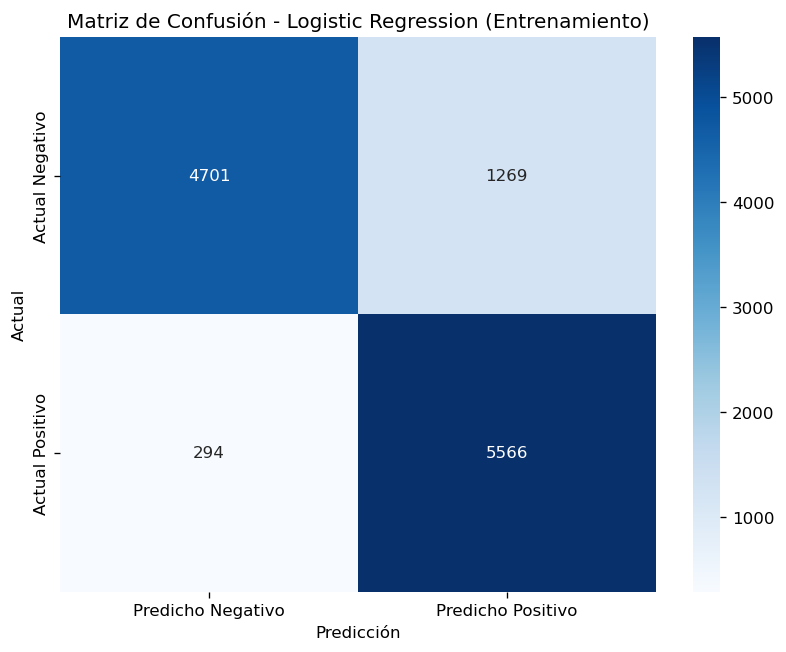

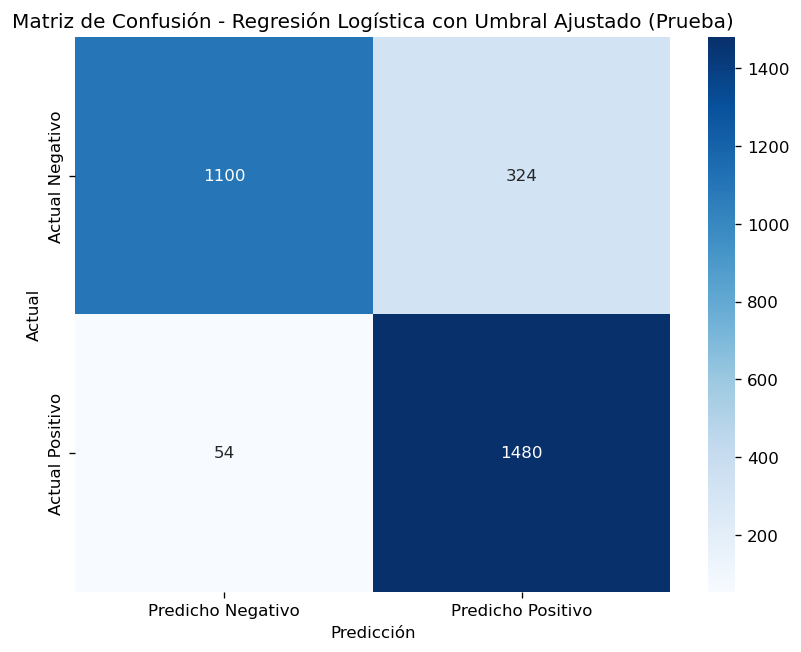

Reporte de clasificación (Entrenamiento):
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      5970
           1       0.81      0.95      0.88      5860

    accuracy                           0.87     11830
   macro avg       0.88      0.87      0.87     11830
weighted avg       0.88      0.87      0.87     11830

Reporte de clasificación (Prueba con Umbral Ajustado):
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      1424
           1       0.82      0.96      0.89      1534

    accuracy                           0.87      2958
   macro avg       0.89      0.87      0.87      2958
weighted avg       0.88      0.87      0.87      2958

Logistic Regression Model Accuracy (Conjunto de Entrenamiento):  0.8621301775147929


In [42]:
# Asegurarse de que las clases estén balanceadas utilizando SMOTE
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Dividir los datos balanceados en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

# Escalado de características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir el modelo Logistic Regression
lr = LogisticRegression(random_state=0, max_iter=1000)
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_lr = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluar el mejor modelo en el conjunto de entrenamiento
y_train_pred = best_lr.predict(X_train)
y_train_probs = best_lr.predict_proba(X_train)[:, 1]

# Evaluar el mejor modelo en el conjunto de prueba
y_test_pred = best_lr.predict(X_test)
y_test_probs = best_lr.predict_proba(X_test)[:, 1]

# Calcular precisión, recall y umbrales para el conjunto de prueba
precision, recall, thresholds = precision_recall_curve(y_test, y_test_probs)

# Calcular F1-Score para cada umbral
f1_scores = 2 * (precision * recall) / (precision + recall)

# Encontrar el índice del mejor F1-Score
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]

print(f"Mejor F1-Score: {f1_scores[best_index]}")
print(f"Mejor Umbral: {best_threshold}")

# Aplicar el mejor umbral para las predicciones del conjunto de prueba
y_test_pred_adjusted = (y_test_probs >= best_threshold).astype(int)

# Calcular la matriz de confusión para el conjunto de entrenamiento
conf_matrix_train = confusion_matrix(y_train, y_train_pred)

# Calcular la nueva matriz de confusión para el conjunto de prueba con umbral ajustado
conf_matrix_test_adjusted = confusion_matrix(y_test, y_test_pred_adjusted)

# Visualizar la matriz de confusión para el conjunto de entrenamiento
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Logistic Regression (Entrenamiento)')
plt.show()

# Visualizar la nueva matriz de confusión para el conjunto de prueba con umbral ajustado
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Regresión Logística con Umbral Ajustado (Prueba)')
plt.show()

# Mostrar el reporte de clasificación para el conjunto de entrenamiento
print("Reporte de clasificación (Entrenamiento):")
print(classification_report(y_train, y_train_pred))

# Mostrar el nuevo reporte de clasificación para el conjunto de prueba con umbral ajustado
print("Reporte de clasificación (Prueba con Umbral Ajustado):")
print(classification_report(y_test, y_test_pred_adjusted))

# Mostrar la exactitud del mejor modelo en el conjunto de entrenamiento
print("Logistic Regression Model Accuracy (Conjunto de Entrenamiento): ", grid_search.best_score_)


### Implementación de Stacking

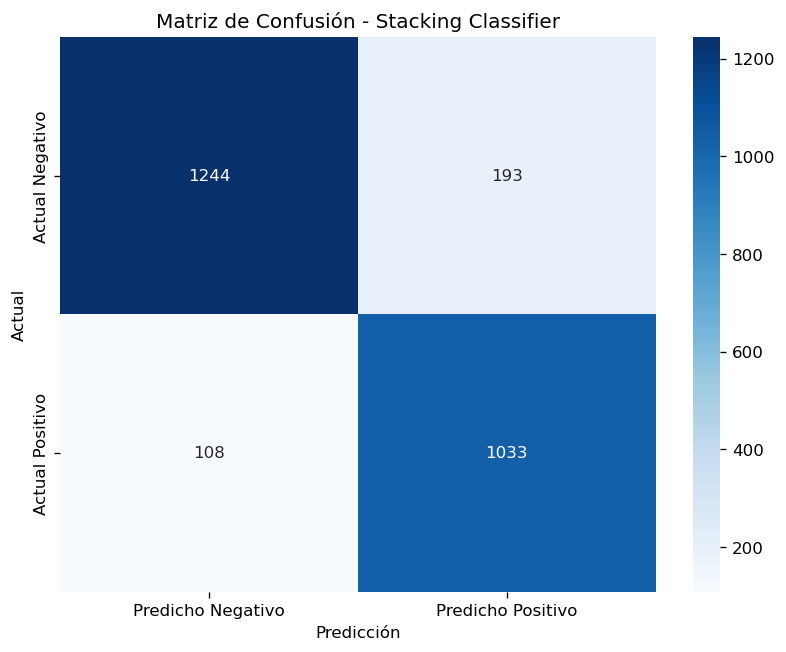

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1437
           1       0.84      0.91      0.87      1141

    accuracy                           0.88      2578
   macro avg       0.88      0.89      0.88      2578
weighted avg       0.89      0.88      0.88      2578

Stacking:  0.8621301775147929


In [44]:
# Definir los modelos base y el modelo meta
estimators = [
    ('decision_tree', DecisionTreeClassifier(random_state=0)),
    ('random_forest', RandomForestClassifier(random_state=0))
]
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=0)
)

# Dividir los datos en conjuntos de entrenamiento y prueba con un tamaño de prueba del 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Aplicar SMOTE para equilibrar las clases
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Entrenar el modelo de stacking
stacking_clf.fit(X_resampled, y_resampled)

# Predecir en el conjunto de prueba
y_pred = stacking_clf.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Stacking Classifier')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred))

# Mostrar la exactitud del mejor modelo
print("Stacking: ", grid_search.best_score_)

In [45]:
### Importancia de las características

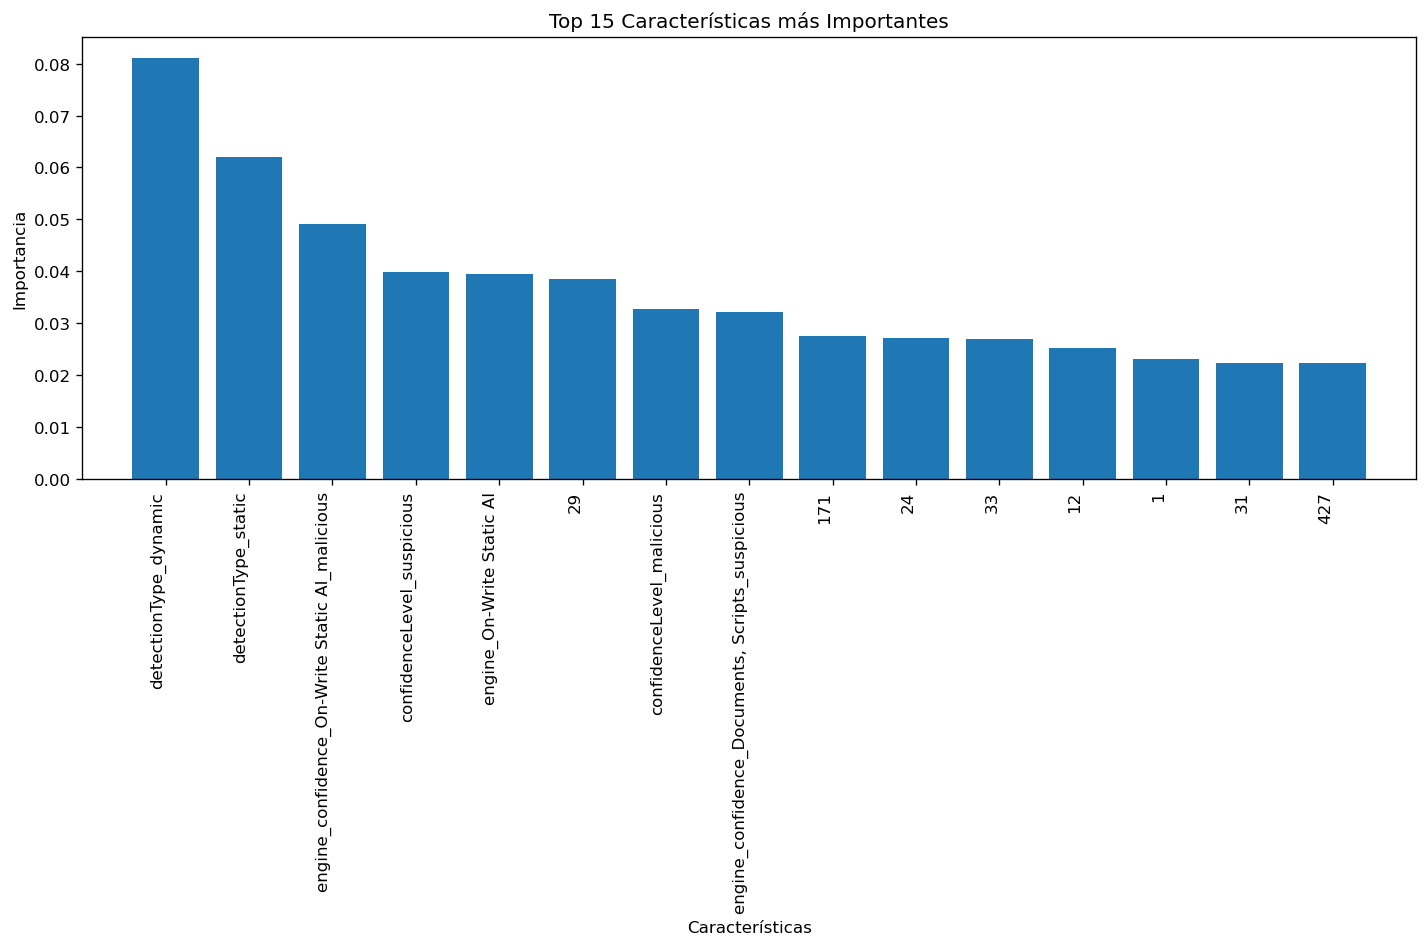

1. detectionType_dynamic (0.08106311626426643)
2. detectionType_static (0.062011499114729016)
3. engine_confidence_On-Write Static AI_malicious (0.04914949910307986)
4. confidenceLevel_suspicious (0.039836849912191)
5. engine_On-Write Static AI (0.03958520069944673)
6. 29 (0.03857238103153227)
7. confidenceLevel_malicious (0.032765280925750234)
8. engine_confidence_Documents, Scripts_suspicious (0.032195242370857566)
9. 171 (0.027483264464509213)
10. 24 (0.027249804803820464)
11. 33 (0.02698323387383231)
12. 12 (0.025219883425707138)
13. 1 (0.023089599246836)
14. 31 (0.022343194725168422)
15. 427 (0.022321447820630787)


In [46]:
# Entrenar un modelo de Random Forest para evaluar la importancia de las características
rf = RandomForestClassifier(random_state=0)
rf.fit(X_resampled, y_resampled)

# Obtener la importancia de las características
importances = rf.feature_importances_

# Ordenar las características por importancia
indices = np.argsort(importances)[::-1]

# Seleccionar las 15 características más importantes
top_n = 15
top_indices = indices[:top_n]

# Visualizar la importancia de las características
plt.figure(figsize=(12, 8))
plt.title("Top 15 Características más Importantes")
plt.bar(range(top_n), importances[top_indices], align="center")
plt.xticks(range(top_n), X.columns[top_indices], rotation=90, ha='right')
plt.xlim([-1, top_n])
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

# Mostrar las 15 características más importantes
for i in range(top_n):
    print(f"{i + 1}. {X.columns[top_indices[i]]} ({importances[top_indices[i]]})")

## Modelo de Naive Bayes

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores hiperparámetros: {'var_smoothing': 1e-05}


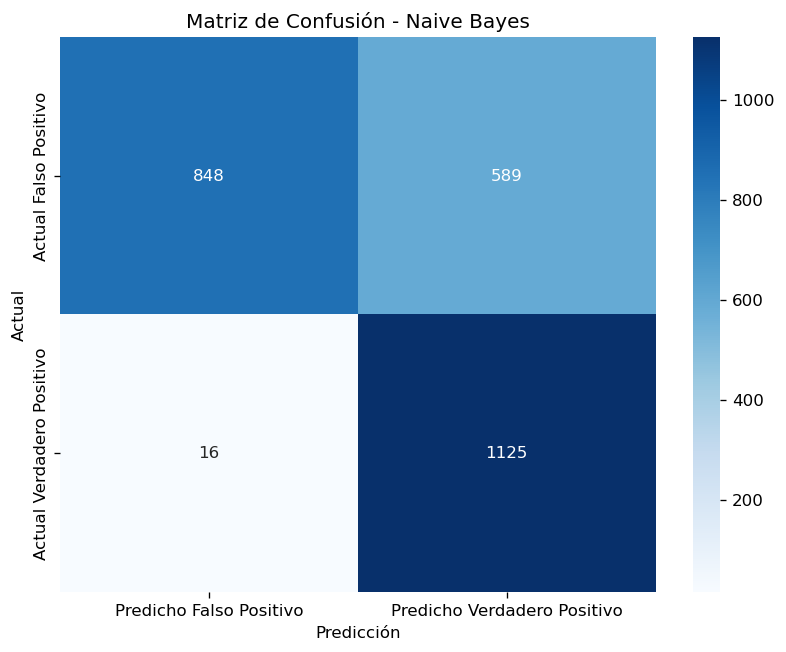

                      precision    recall  f1-score   support

    Falsos Positivos       0.98      0.59      0.74      1437
Verdaderos Positivos       0.66      0.99      0.79      1141

            accuracy                           0.77      2578
           macro avg       0.82      0.79      0.76      2578
        weighted avg       0.84      0.77      0.76      2578

Naive Bayes Model Cross-Validation Accuracy:  0.7909179314857233


In [47]:
# Crear el modelo GaussianNB
model = GaussianNB()

# Definir los hiperparámetros para buscar
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Realizar búsqueda de hiperparámetros con validación cruzada
grid_search.fit(X_resampled, y_resampled)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Usar el mejor modelo para predecir en el conjunto de prueba
best_model = grid_search.best_estimator_

# Realizar validación cruzada con el mejor modelo
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='accuracy')

# Ajustar el mejor modelo en todo el conjunto de entrenamiento resampleado
best_model.fit(X_resampled, y_resampled)

# Predecir en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Falso Positivo', 'Predicho Verdadero Positivo'], yticklabels=['Actual Falso Positivo', 'Actual Verdadero Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Naive Bayes')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Falsos Positivos', 'Verdaderos Positivos']))

# Mostrar la exactitud del modelo Naive Bayes con validación cruzada
print("Naive Bayes Model Cross-Validation Accuracy: ", cv_scores.mean())


### Modelo de Naive Bayes comparando con entrenamiento

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores hiperparámetros: {'var_smoothing': 1e-05}


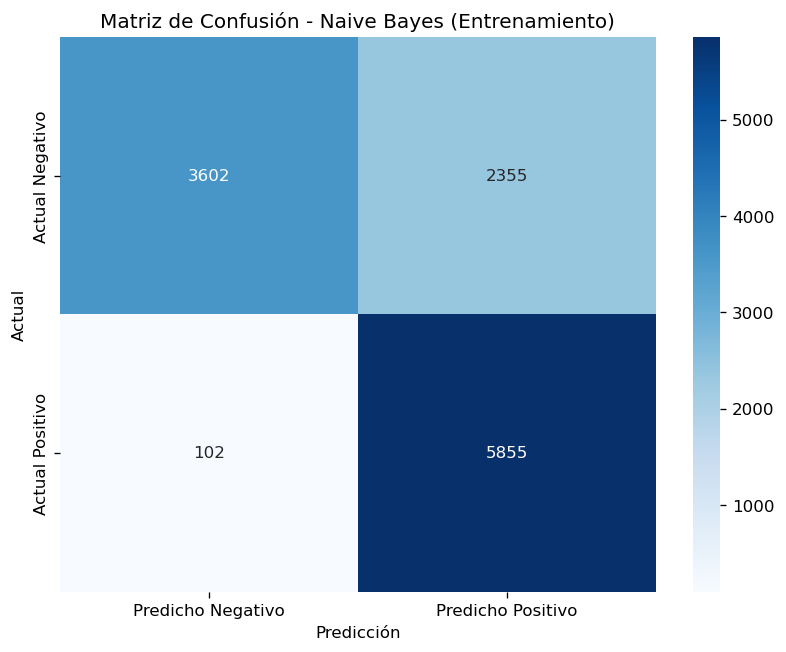

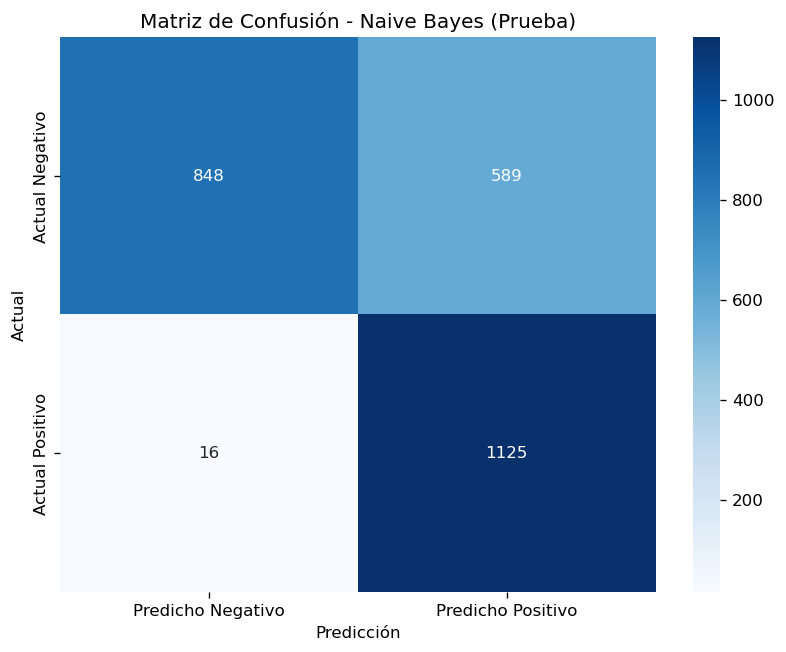

Reporte de clasificación (Entrenamiento):
                      precision    recall  f1-score   support

    Falsos Positivos       0.97      0.60      0.75      5957
Verdaderos Positivos       0.71      0.98      0.83      5957

            accuracy                           0.79     11914
           macro avg       0.84      0.79      0.79     11914
        weighted avg       0.84      0.79      0.79     11914

Reporte de clasificación (Prueba):
                      precision    recall  f1-score   support

    Falsos Positivos       0.98      0.59      0.74      1437
Verdaderos Positivos       0.66      0.99      0.79      1141

            accuracy                           0.77      2578
           macro avg       0.82      0.79      0.76      2578
        weighted avg       0.84      0.77      0.76      2578

Naive Bayes Model Cross-Validation Accuracy:  0.7909179314857233


In [48]:
# Crear el modelo GaussianNB
model = GaussianNB()

# Definir los hiperparámetros para buscar
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Realizar búsqueda de hiperparámetros con validación cruzada
grid_search.fit(X_resampled, y_resampled)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Usar el mejor modelo para predecir en el conjunto de prueba
best_model = grid_search.best_estimator_

# Realizar validación cruzada con el mejor modelo
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='accuracy')

# Ajustar el mejor modelo en todo el conjunto de entrenamiento resampleado
best_model.fit(X_resampled, y_resampled)

# Predecir en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_resampled)

# Predecir en el conjunto de prueba
y_test_pred = best_model.predict(X_test)

# Calcular la matriz de confusión para el conjunto de entrenamiento
conf_matrix_train = confusion_matrix(y_resampled, y_train_pred)

# Calcular la matriz de confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Visualizar la matriz de confusión para el conjunto de entrenamiento
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Naive Bayes (Entrenamiento)')
plt.show()

# Visualizar la matriz de confusión para el conjunto de prueba
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Naive Bayes (Prueba)')
plt.show()

# Mostrar el reporte de clasificación para el conjunto de entrenamiento
print("Reporte de clasificación (Entrenamiento):")
print(classification_report(y_resampled, y_train_pred, target_names=['Falsos Positivos', 'Verdaderos Positivos']))

# Mostrar el reporte de clasificación para el conjunto de prueba
print("Reporte de clasificación (Prueba):")
print(classification_report(y_test, y_test_pred, target_names=['Falsos Positivos', 'Verdaderos Positivos']))

# Mostrar la exactitud del modelo Naive Bayes con validación cruzada
print("Naive Bayes Model Cross-Validation Accuracy: ", cv_scores.mean())


## Modelo SVM

Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\alber\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


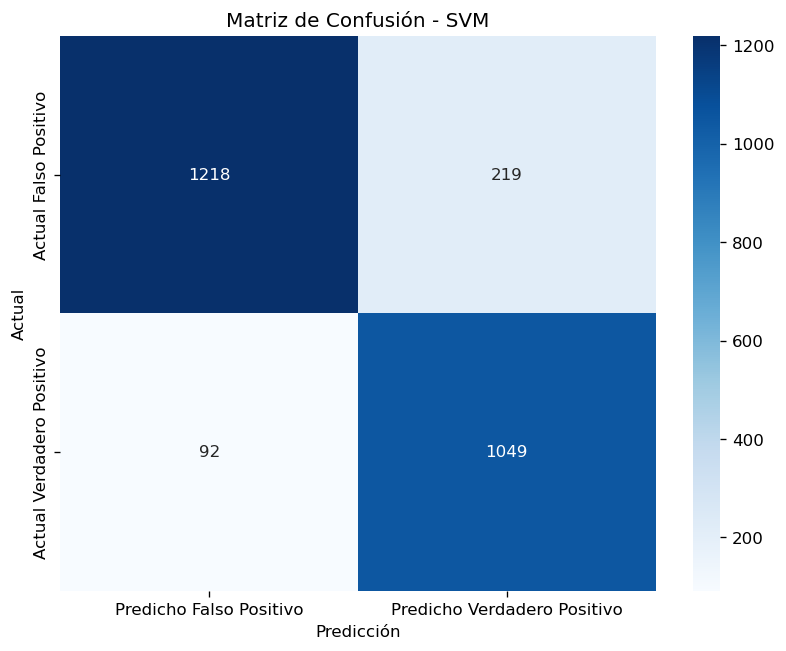

                      precision    recall  f1-score   support

    Falsos Positivos       0.93      0.85      0.89      1437
Verdaderos Positivos       0.83      0.92      0.87      1141

            accuracy                           0.88      2578
           macro avg       0.88      0.88      0.88      2578
        weighted avg       0.88      0.88      0.88      2578

SVM Model Cross-Validation Accuracy:  0.8855136773810293


In [49]:
# Crear el modelo SVM
model = SVC()

# Definir los hiperparámetros para buscar
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Realizar búsqueda de hiperparámetros con validación cruzada
grid_search.fit(X_resampled, y_resampled)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Usar el mejor modelo para predecir en el conjunto de prueba
best_model = grid_search.best_estimator_

# Realizar validación cruzada con el mejor modelo
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='accuracy')

# Ajustar el mejor modelo en todo el conjunto de entrenamiento resampleado
best_model.fit(X_resampled, y_resampled)

# Predecir en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Falso Positivo', 'Predicho Verdadero Positivo'], yticklabels=['Actual Falso Positivo', 'Actual Verdadero Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - SVM')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Falsos Positivos', 'Verdaderos Positivos']))

# Mostrar la exactitud del modelo SVM con validación cruzada
print("SVM Model Cross-Validation Accuracy: ", cv_scores.mean())

In [50]:
### Modelo SVM analizando el sobreajuste

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores hiperparámetros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


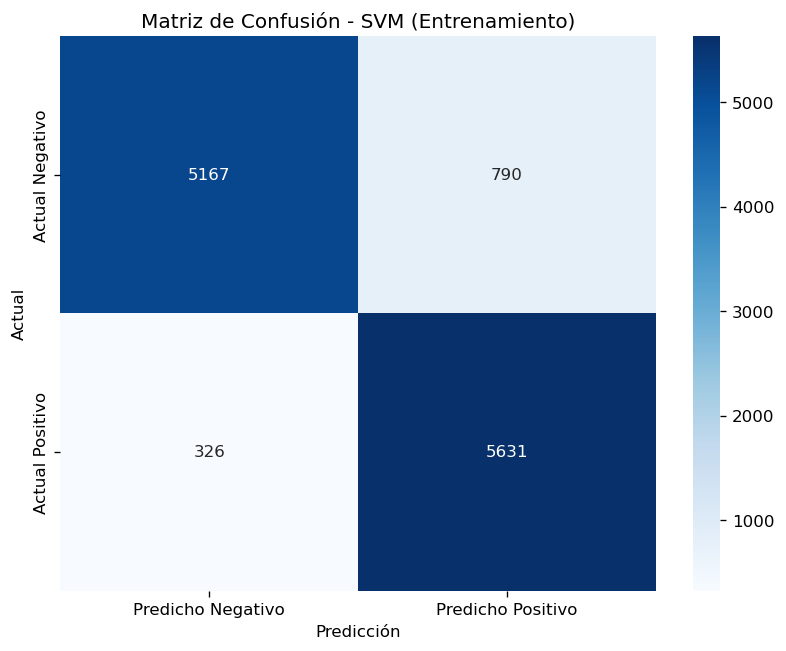

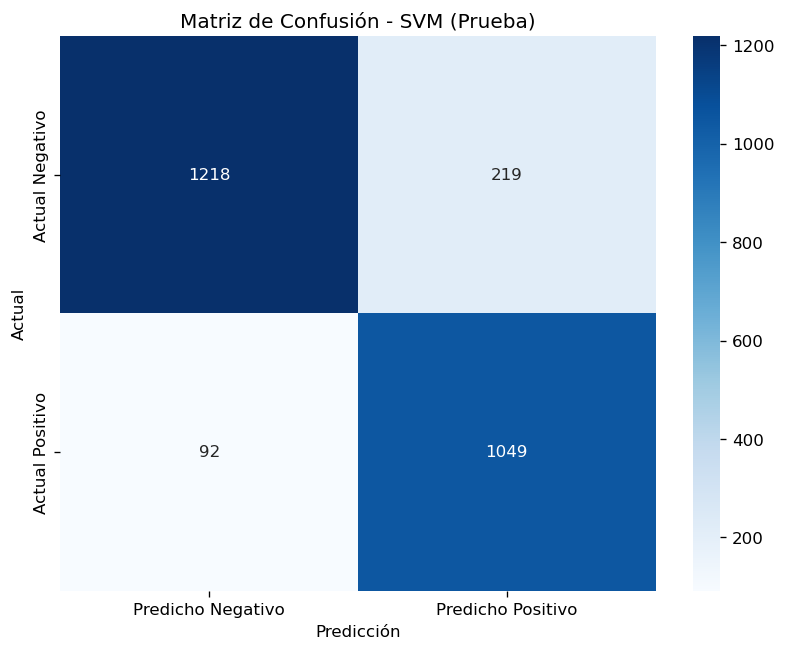

Reporte de clasificación (Entrenamiento):
                      precision    recall  f1-score   support

    Falsos Positivos       0.94      0.87      0.90      5957
Verdaderos Positivos       0.88      0.95      0.91      5957

            accuracy                           0.91     11914
           macro avg       0.91      0.91      0.91     11914
        weighted avg       0.91      0.91      0.91     11914

Reporte de clasificación (Prueba):
                      precision    recall  f1-score   support

    Falsos Positivos       0.93      0.85      0.89      1437
Verdaderos Positivos       0.83      0.92      0.87      1141

            accuracy                           0.88      2578
           macro avg       0.88      0.88      0.88      2578
        weighted avg       0.88      0.88      0.88      2578

SVM Model Cross-Validation Accuracy:  0.8855136773810293


In [51]:
# Crear el modelo SVM
model = SVC(probability=True)

# Definir los hiperparámetros para buscar
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Realizar búsqueda de hiperparámetros con validación cruzada
grid_search.fit(X_resampled, y_resampled)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Usar el mejor modelo para predecir en el conjunto de prueba
best_model = grid_search.best_estimator_

# Realizar validación cruzada con el mejor modelo
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='accuracy')

# Ajustar el mejor modelo en todo el conjunto de entrenamiento resampleado
best_model.fit(X_resampled, y_resampled)

# Predecir en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_resampled)

# Predecir en el conjunto de prueba
y_test_pred = best_model.predict(X_test)

# Calcular la matriz de confusión para el conjunto de entrenamiento
conf_matrix_train = confusion_matrix(y_resampled, y_train_pred)

# Calcular la matriz de confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Visualizar la matriz de confusión para el conjunto de entrenamiento
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - SVM (Entrenamiento)')
plt.show()

# Visualizar la matriz de confusión para el conjunto de prueba
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - SVM (Prueba)')
plt.show()

# Mostrar el reporte de clasificación para el conjunto de entrenamiento
print("Reporte de clasificación (Entrenamiento):")
print(classification_report(y_resampled, y_train_pred, target_names=['Falsos Positivos', 'Verdaderos Positivos']))

# Mostrar el reporte de clasificación para el conjunto de prueba
print("Reporte de clasificación (Prueba):")
print(classification_report(y_test, y_test_pred, target_names=['Falsos Positivos', 'Verdaderos Positivos']))

# Mostrar la exactitud del modelo SVM con validación cruzada
print("SVM Model Cross-Validation Accuracy: ", cv_scores.mean())


## AdaBoost

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\alber\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Mejores hiperparámetros: {'estimator__max_depth': 3, 'learning_rate': 1, 'n_estimators': 200}


C:\Users\alber\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alber\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alber\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alber\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alb

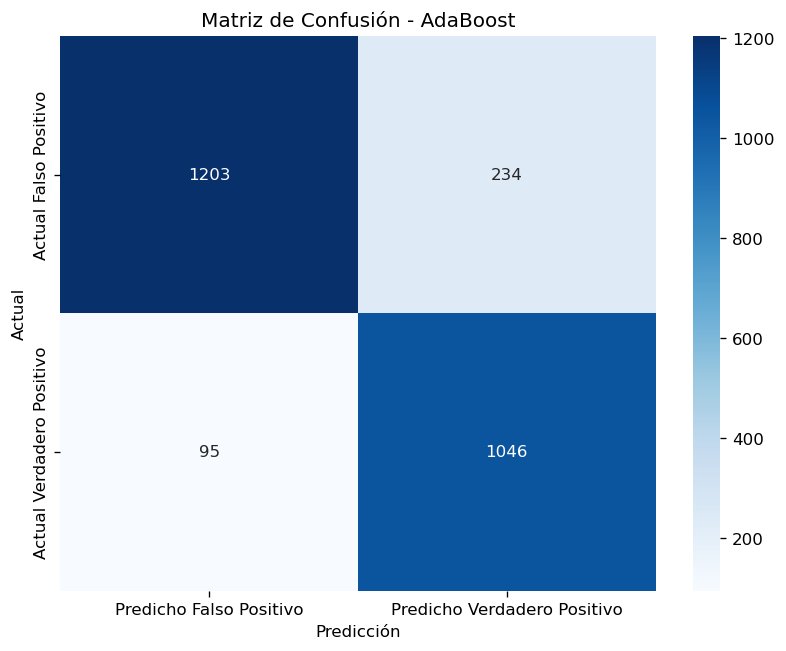

                      precision    recall  f1-score   support

    Falsos Positivos       0.93      0.84      0.88      1437
Verdaderos Positivos       0.82      0.92      0.86      1141

            accuracy                           0.87      2578
           macro avg       0.87      0.88      0.87      2578
        weighted avg       0.88      0.87      0.87      2578

AdaBoost Model Cross-Validation Accuracy:  0.8803100467099554


In [52]:
# Crear el modelo base
base_estimator = DecisionTreeClassifier()

# Definir los hiperparámetros para buscar
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'estimator__max_depth': [1, 2, 3]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=AdaBoostClassifier(estimator=base_estimator, random_state=0),
                           param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Realizar búsqueda de hiperparámetros con validación cruzada
grid_search.fit(X_resampled, y_resampled)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Usar el mejor modelo para predecir en el conjunto de prueba
best_model = grid_search.best_estimator_

# Realizar validación cruzada con el mejor modelo
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='accuracy')

# Ajustar el mejor modelo en todo el conjunto de entrenamiento resampleado
best_model.fit(X_resampled, y_resampled)

# Predecir en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Falso Positivo', 'Predicho Verdadero Positivo'], yticklabels=['Actual Falso Positivo', 'Actual Verdadero Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - AdaBoost')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Falsos Positivos', 'Verdaderos Positivos']))

# Mostrar la exactitud del modelo AdaBoost con validación cruzada
print("AdaBoost Model Cross-Validation Accuracy: ", cv_scores.mean())

### AdaBoost analizando sobreajuste

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\alber\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Mejores hiperparámetros: {'estimator__max_depth': 3, 'learning_rate': 1, 'n_estimators': 200}


C:\Users\alber\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alber\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alber\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alber\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alb

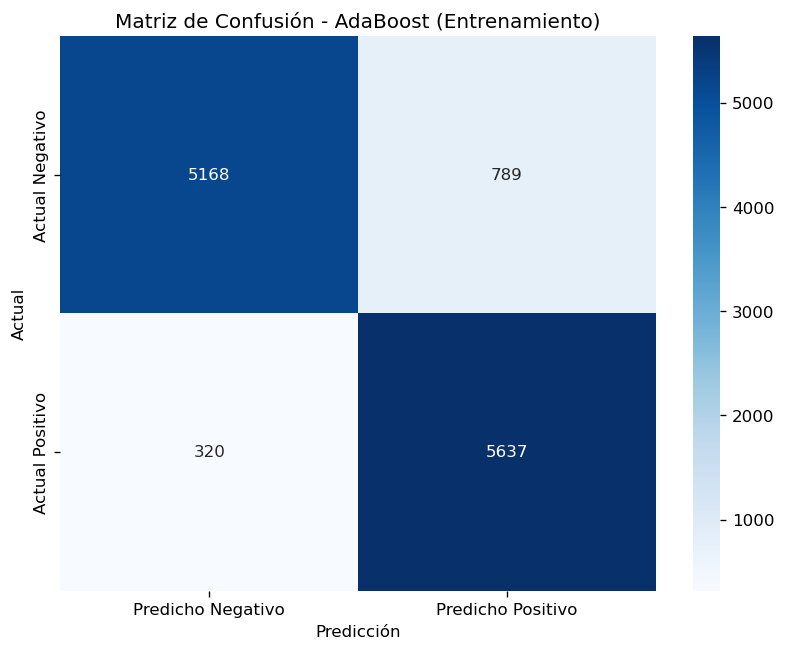

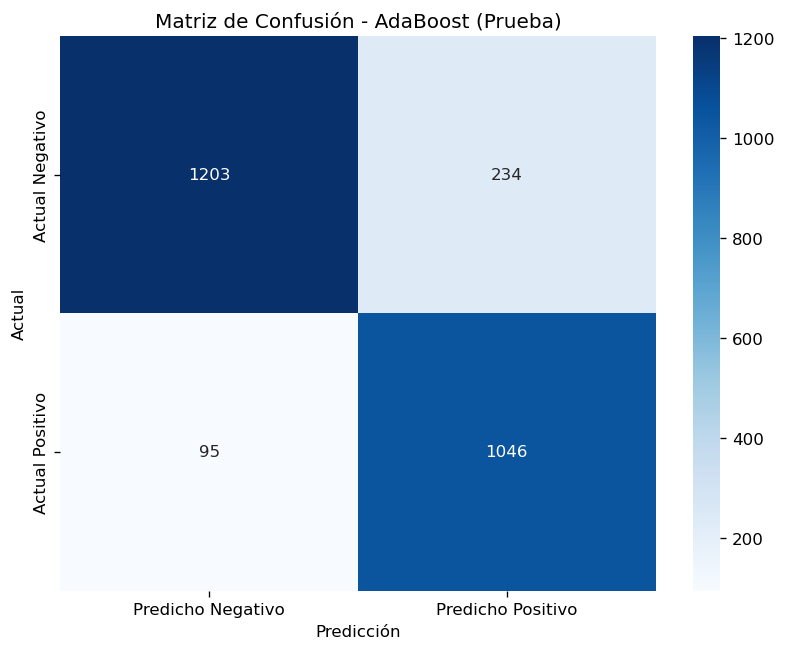

Reporte de clasificación (Entrenamiento):
                      precision    recall  f1-score   support

    Falsos Positivos       0.94      0.87      0.90      5957
Verdaderos Positivos       0.88      0.95      0.91      5957

            accuracy                           0.91     11914
           macro avg       0.91      0.91      0.91     11914
        weighted avg       0.91      0.91      0.91     11914

Reporte de clasificación (Prueba):
                      precision    recall  f1-score   support

    Falsos Positivos       0.93      0.84      0.88      1437
Verdaderos Positivos       0.82      0.92      0.86      1141

            accuracy                           0.87      2578
           macro avg       0.87      0.88      0.87      2578
        weighted avg       0.88      0.87      0.87      2578

AdaBoost Model Cross-Validation Accuracy:  0.8803100467099554


In [53]:
# Crear el modelo base
base_estimator = DecisionTreeClassifier()

# Definir los hiperparámetros para buscar
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'estimator__max_depth': [1, 2, 3]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=AdaBoostClassifier(estimator=base_estimator, random_state=0),
                           param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Realizar búsqueda de hiperparámetros con validación cruzada
grid_search.fit(X_resampled, y_resampled)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Usar el mejor modelo para predecir en el conjunto de prueba
best_model = grid_search.best_estimator_

# Realizar validación cruzada con el mejor modelo
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='accuracy')

# Ajustar el mejor modelo en todo el conjunto de entrenamiento resampleado
best_model.fit(X_resampled, y_resampled)

# Predecir en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_resampled)

# Predecir en el conjunto de prueba
y_test_pred = best_model.predict(X_test)

# Calcular la matriz de confusión para el conjunto de entrenamiento
conf_matrix_train = confusion_matrix(y_resampled, y_train_pred)

# Calcular la matriz de confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Visualizar la matriz de confusión para el conjunto de entrenamiento
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - AdaBoost (Entrenamiento)')
plt.show()

# Visualizar la matriz de confusión para el conjunto de prueba
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - AdaBoost (Prueba)')
plt.show()

# Mostrar el reporte de clasificación para el conjunto de entrenamiento
print("Reporte de clasificación (Entrenamiento):")
print(classification_report(y_resampled, y_train_pred, target_names=['Falsos Positivos', 'Verdaderos Positivos']))

# Mostrar el reporte de clasificación para el conjunto de prueba
print("Reporte de clasificación (Prueba):")
print(classification_report(y_test, y_test_pred, target_names=['Falsos Positivos', 'Verdaderos Positivos']))

# Mostrar la exactitud del modelo AdaBoost con validación cruzada
print("AdaBoost Model Cross-Validation Accuracy: ", cv_scores.mean())


## Modelo de XGBoost

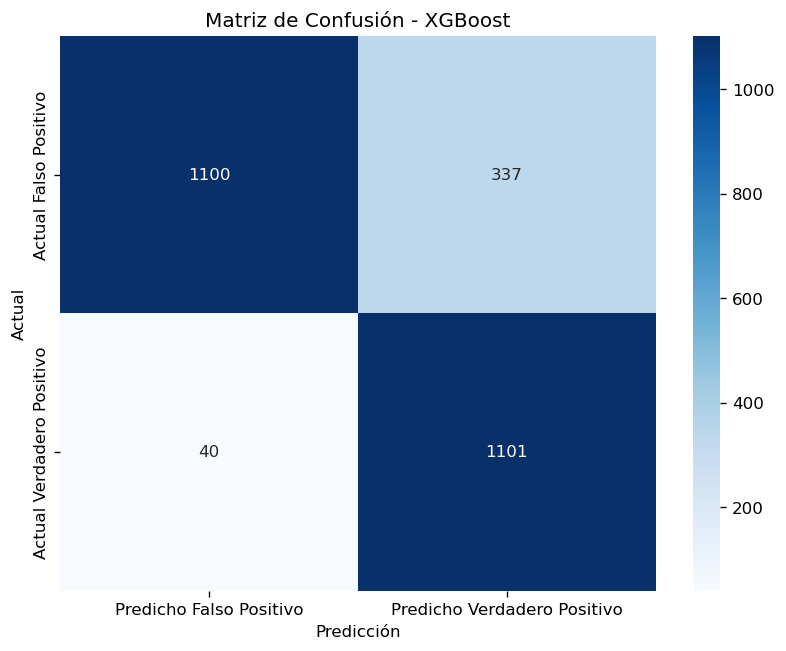

                      precision    recall  f1-score   support

    Falsos Positivos       0.96      0.77      0.85      1437
Verdaderos Positivos       0.77      0.96      0.85      1141

            accuracy                           0.85      2578
           macro avg       0.87      0.87      0.85      2578
        weighted avg       0.88      0.85      0.85      2578



In [54]:
# Crear los DMatrix para el entrenamiento y el conjunto de prueba
dtrain = xgb.DMatrix(X_resampled, label=y_resampled)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parámetros del modelo
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'eta': 0.1,
    'eval_metric': 'logloss'
}

# Entrenar el modelo
bst = xgb.train(params, dtrain, num_boost_round=50)

# Predecir en el conjunto de prueba
y_pred_prob = bst.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Falso Positivo', 'Predicho Verdadero Positivo'], yticklabels=['Actual Falso Positivo', 'Actual Verdadero Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - XGBoost')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Falsos Positivos', 'Verdaderos Positivos']))

### Modelo de XGBoost analizando sobreajuste

Fitting 5 folds for each of 162 candidates, totalling 810 fits


C:\Users\alber\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\alber\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:37:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores hiperparámetros: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200}


C:\Users\alber\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:37:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


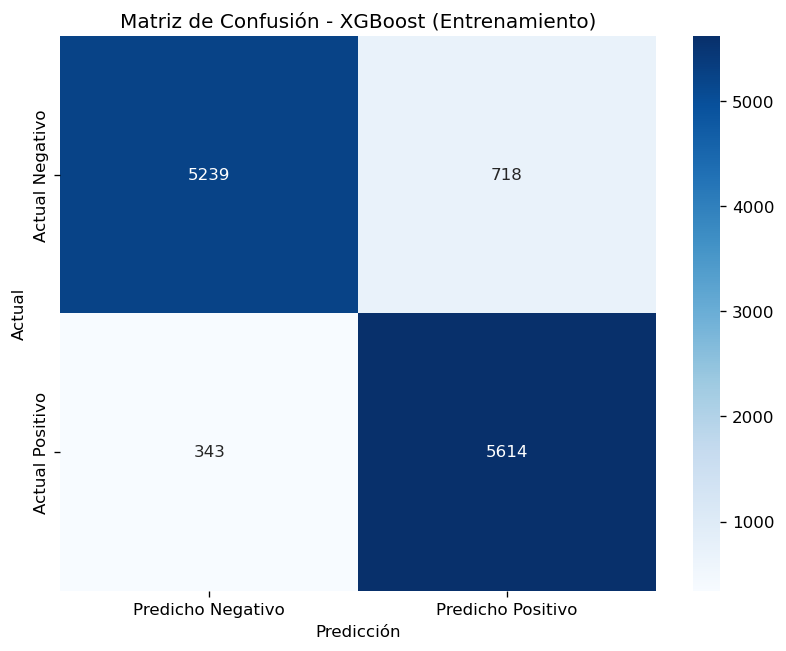

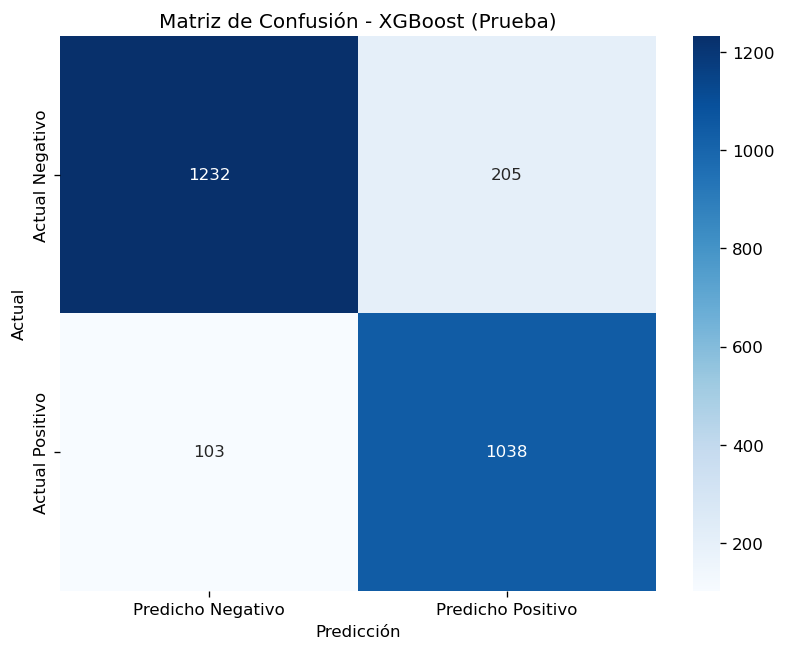

Reporte de clasificación (Entrenamiento):
                      precision    recall  f1-score   support

    Falsos Positivos       0.94      0.88      0.91      5957
Verdaderos Positivos       0.89      0.94      0.91      5957

            accuracy                           0.91     11914
           macro avg       0.91      0.91      0.91     11914
        weighted avg       0.91      0.91      0.91     11914

Reporte de clasificación (Prueba):
                      precision    recall  f1-score   support

    Falsos Positivos       0.92      0.86      0.89      1437
Verdaderos Positivos       0.84      0.91      0.87      1141

            accuracy                           0.88      2578
           macro avg       0.88      0.88      0.88      2578
        weighted avg       0.88      0.88      0.88      2578



In [55]:
# Definir el modelo XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Definir los hiperparámetros para buscar
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.3, 0.7]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Realizar búsqueda de hiperparámetros con validación cruzada
grid_search.fit(X_resampled, y_resampled)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Usar el mejor modelo para predecir en el conjunto de prueba
best_model = grid_search.best_estimator_

# Ajustar el mejor modelo en todo el conjunto de entrenamiento resampleado
best_model.fit(X_resampled, y_resampled)

# Predecir en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_resampled)

# Predecir en el conjunto de prueba
y_test_pred = best_model.predict(X_test)

# Calcular la matriz de confusión para el conjunto de entrenamiento
conf_matrix_train = confusion_matrix(y_resampled, y_train_pred)

# Calcular la matriz de confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Visualizar la matriz de confusión para el conjunto de entrenamiento
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - XGBoost (Entrenamiento)')
plt.show()

# Visualizar la matriz de confusión para el conjunto de prueba
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - XGBoost (Prueba)')
plt.show()

# Mostrar el reporte de clasificación para el conjunto de entrenamiento
print("Reporte de clasificación (Entrenamiento):")
print(classification_report(y_resampled, y_train_pred, target_names=['Falsos Positivos', 'Verdaderos Positivos']))

# Mostrar el reporte de clasificación para el conjunto de prueba
print("Reporte de clasificación (Prueba):")
print(classification_report(y_test, y_test_pred, target_names=['Falsos Positivos', 'Verdaderos Positivos']))


# Evaluación y comparativa

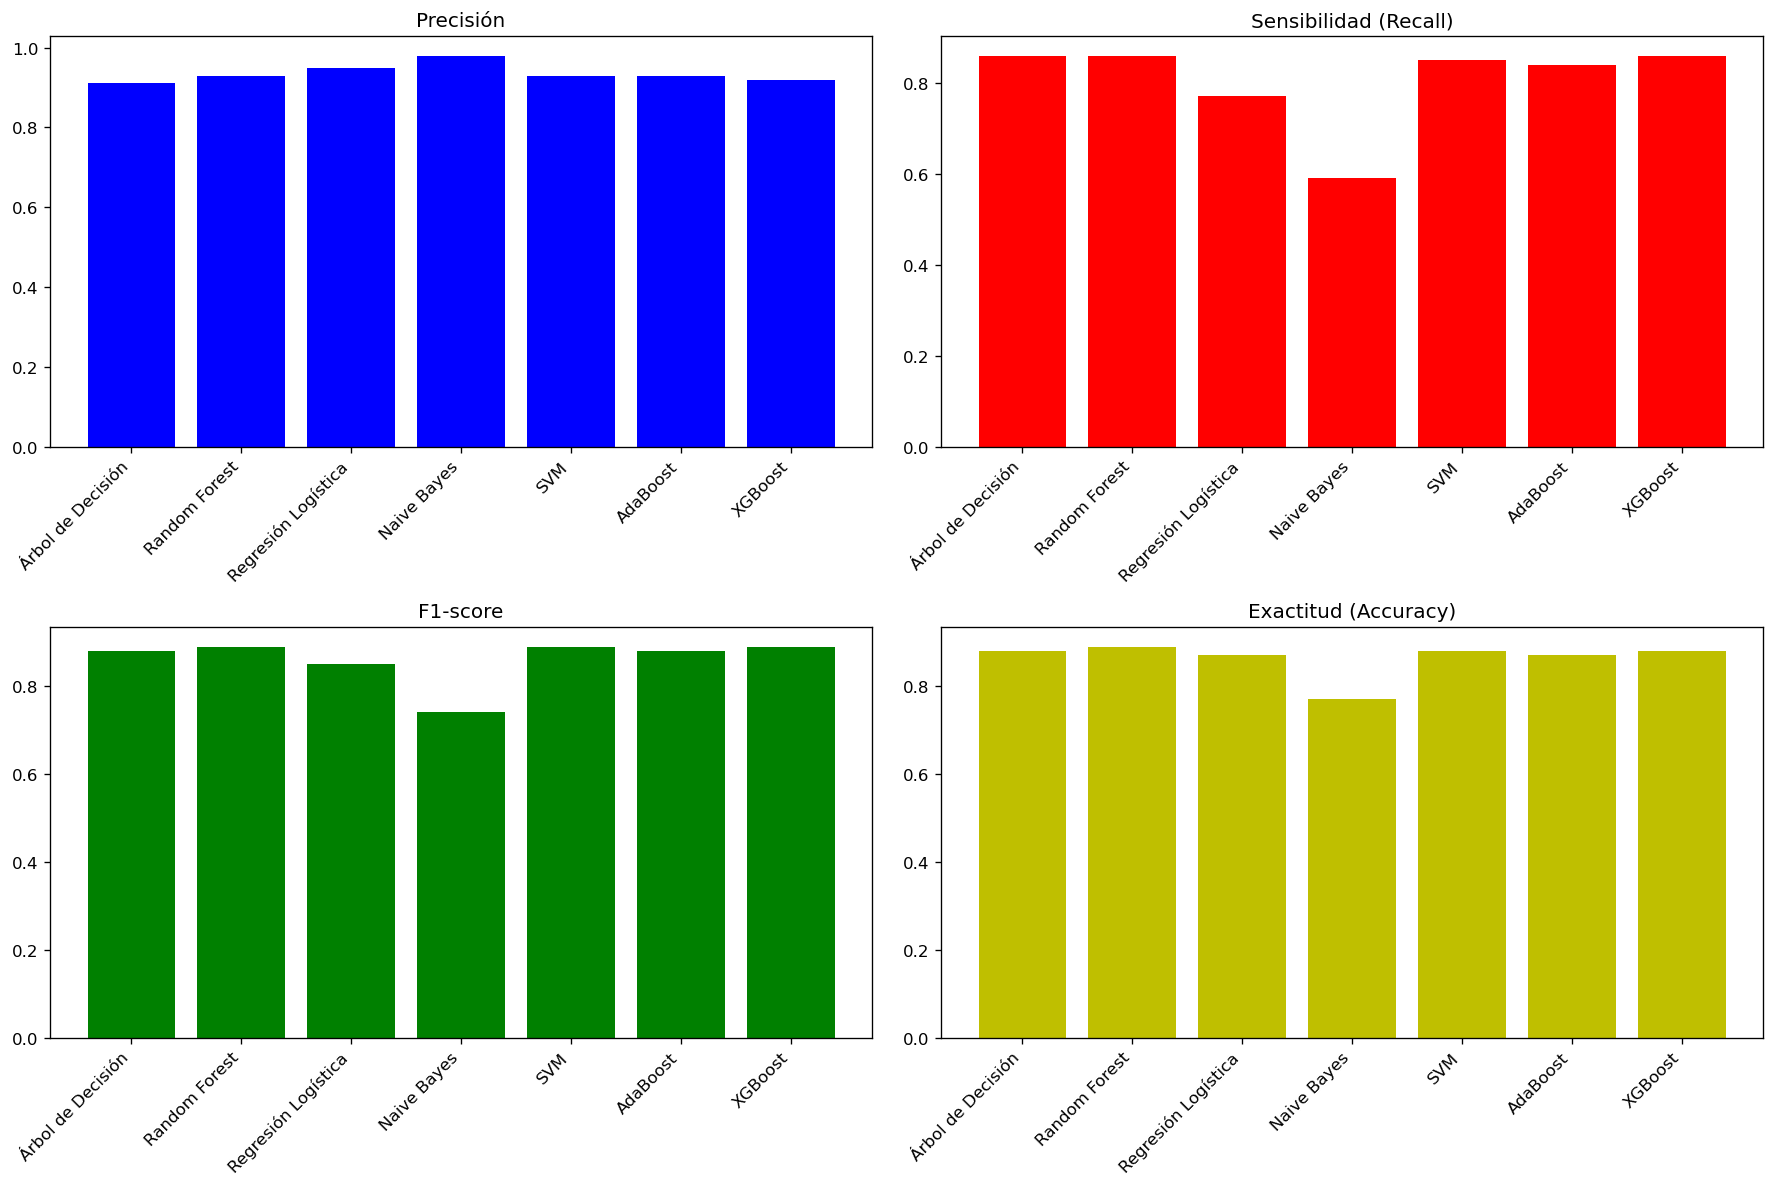

In [56]:
# Datos de las métricas
models = ['Árbol de Decisión', 'Random Forest', 'Regresión Logística', 'Naive Bayes', 'SVM', 'AdaBoost', 'XGBoost']
precision = [0.91, 0.93, 0.95, 0.98, 0.93, 0.93, 0.92]
recall = [0.86, 0.86, 0.77, 0.59, 0.85, 0.84, 0.86]
f1_score = [0.88, 0.89, 0.85, 0.74, 0.89, 0.88, 0.89]
accuracy = [0.88, 0.89, 0.87, 0.77, 0.88, 0.87, 0.88]

x = np.arange(len(models))

# Crear subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Precision
axs[0, 0].bar(x, precision, color='b')
axs[0, 0].set_title('Precisión')
axs[0, 0].set_xticks(x)
axs[0, 0].set_xticklabels(models, rotation=45, ha='right')

# Recall
axs[0, 1].bar(x, recall, color='r')
axs[0, 1].set_title('Sensibilidad (Recall)')
axs[0, 1].set_xticks(x)
axs[0, 1].set_xticklabels(models, rotation=45, ha='right')

# F1-score
axs[1, 0].bar(x, f1_score, color='g')
axs[1, 0].set_title('F1-score')
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(models, rotation=45, ha='right')

# Accuracy
axs[1, 1].bar(x, accuracy, color='y')
axs[1, 1].set_title('Exactitud (Accuracy)')
axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(models, rotation=45, ha='right')

plt.tight_layout()
plt.show()